# **1. Data Exploration and Preprocessing**

## **1.1 Load and explore**

### a. Set up libraries, reproducibility seed

In [1]:
pip install wordcloud matplotlib langchain-text-splitters chromadb datasets sentence-transformers transformers accelerate gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.2 MB/s eta 0:

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import chromadb
import torch
import random
import traceback
import gradio as gr

In [3]:
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from pprint import pprint
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sentence_transformers import SentenceTransformer
from langchain_text_splitters import RecursiveCharacterTextSplitter
from hashlib import md5
from datasets import Dataset, DatasetDict
from sklearn.metrics.pairwise import cosine_similarity
from transformers import(
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    GenerationConfig,
    EarlyStoppingCallback,
    AutoModelForSequenceClassification,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer)

In [4]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1)

### b. Data

In [5]:
url = "https://raw.githubusercontent.com/AmiraFaisal/Scenario2/main/MedQuAD_Dataset_RAG_Scenario.csv"
df = pd.read_csv(url, header = 0)
df.head()

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [6]:
def get_column_stats(dataframe):
    """Calculate Min, Max, and Average for all columns.
    Returns: DataFrame"""
    stats = {}

    for col in dataframe.columns:
        series = dataframe[col]

        if pd.api.types.is_numeric_dtype(series):
            # Numeric columns: calculate stats on the values
            stats[col] = {
                'Type': 'Numeric',
                'Min': series.min(),
                'Max': series.max(),
                'Average': series.mean(),
            }

        elif pd.api.types.is_string_dtype(series) or series.dtype == 'object':
            # String/Object columns: calculate stats on the string length
            lengths = series.astype(str).str.len()

            stats[col] = {
                'Type': 'String/Text',
                'Min Length': lengths.min(),
                'Max Length': lengths.max(),
                'Average Length': lengths.mean(),
            }

        else:
            stats[col] = {'Type': str(series.dtype), 'Note': 'Stats not calculated'}

    # Convert the results dictionary into a readable DataFrame
    return pd.DataFrame(stats).T.round(2)

# Run the function on the sample DataFrame
summary_df = get_column_stats(df)

print("-------------------- Column Stats Summary -------------------")
print(summary_df)
print("-------------------------------------------------------------")

-------------------- Column Stats Summary -------------------
                   Type Min Length Max Length Average Length
question    String/Text         16        191      50.684438
answer      String/Text          3      29046    1300.793992
source      String/Text          3         17       5.340239
focus_area  String/Text          3        136      26.225018
-------------------------------------------------------------


In [7]:
def filterByLength(df: pd.DataFrame, column_name: str, min_length: int) -> pd.DataFrame:
    """Remove rows where column length is less than minimum threshold.
    Returns: DataFrame"""

    print(f"--- Filtering '{column_name}': Removing rows with length < {min_length} ---")

    # 1. Safely calculate the length of every cell (converting to string first)
    string_lengths = df[column_name].astype(str).str.len()

    # 2. Create a boolean mask: True where length is >= min_length
    complete_mask = string_lengths >= min_length

    # 3. Filter the DataFrame and return the result
    return df[complete_mask].copy() # Use .copy() to ensure a new DataFrame is returned


print(f"Original Row Count: {len(df)}")
# Clean the 'answer' and 'answer' columns with length under 20 words
df = filterByLength(
    df=df,
    column_name='question',
    min_length=20
)
print(f"Row Count after 'question' filter: {len(df)} \n")

df = filterByLength(
    df=df,
    column_name='answer',
    min_length=20
)
print(f"Row Count after 'answer' filter: {len(df)}")

Original Row Count: 16412
--- Filtering 'question': Removing rows with length < 20 ---
Row Count after 'question' filter: 16399 

--- Filtering 'answer': Removing rows with length < 20 ---
Row Count after 'answer' filter: 16356


In [8]:
# 1. Fill NaN values
answers = df['answer'].fillna('')

# 2. Total number of non-empty answers (used for percentage calculation)
non_empty_answers = (answers != '').sum()

# 3. Check how many contain a question mark ('?') anywhere in the string
contains_question_mark = answers.str.contains(r'\?', regex=True)
count_contains_qm = contains_question_mark.sum()

# 4. Calculate percentage
percentage_contains_qm = (count_contains_qm / non_empty_answers) * 100 if non_empty_answers > 0 else 0

print(f"Total non-empty entries in 'answer' column: {non_empty_answers}")
print(f"Number of non-empty entries that contain a question mark ('?'): {count_contains_qm}")
print(f"Percentage of non-empty entries that contain a question mark ('?'): {percentage_contains_qm:.2f}%")

Total non-empty entries in 'answer' column: 16356
Number of non-empty entries that contain a question mark ('?'): 4236
Percentage of non-empty entries that contain a question mark ('?'): 25.90%


In [9]:
example_index_to_check = 545
print(f"Original Answer (ID {example_index_to_check}) before cleaning (from df):\n{df.loc[example_index_to_check, 'answer']}\n")
cleaned_answers_series = pd.Series(index=df.index, dtype=str)
for idx, original_answer in df['answer'].items():
    if not isinstance(original_answer, str):
        cleaned_answers_series.loc[idx] = original_answer
        continue
    segments = re.split(r'([.!?]\s*)', original_answer)

    cleaned_segments = []
    i = 0
    while i < len(segments):
        content = segments[i].strip()
        delimiter_and_space = segments[i+1] if i+1 < len(segments) else ''
        full_sentence_candidate = content + delimiter_and_space.strip()
        if not full_sentence_candidate.endswith('?'):
            cleaned_segments.append(segments[i])
            if i + 1 < len(segments):
                cleaned_segments.append(segments[i+1])
        i += 2

    cleaned_text = ''.join(cleaned_segments).strip()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    cleaned_answers_series.loc[idx] = cleaned_text
df['answer'] = cleaned_answers_series

answers_after_cleaning = df['answer']
contains_question_mark_after_cleaning = answers_after_cleaning.str.contains(r'\?', regex=True, na=False)

print(f"Cleaned Answer (ID {example_index_to_check}):\n{cleaned_answers_series.loc[example_index_to_check]}\n")
if contains_question_mark_after_cleaning.any():
    print("Some answers still contain question marks after cleaning.")
else:
    print("'answer' column has been updated, and no sentences ending with '?' should remain.")

print(f"Row Count: {len(df)}")

Original Answer (ID 545) before cleaning (from df):
What is Cholesterol? Cholesterol is a waxy, fat-like substance that your liver makes. It is also found in some foods that come from animals. Cholesterol is found in all parts of your body. It plays a vital role in your body. It makes hormones, helps you digest food, and supports the workings of all the cells in your body. But your liver makes all the cholesterol that your body needs to do this. Lipoproteins and Cholesterol Cholesterol circulates in your blood stream. But it's fatty while your blood is watery. Just like oil and water, the two do not mix. As a result, cholesterol travels through your bloodstream in small packages called lipoproteins. The packages are made of fat (lipids) on the inside and proteins on the outside. Two kinds of lipoproteins carry cholesterol through your bloodstream. It's important to have healthy levels of both: - low-density lipoproteins (LDL)  - high-density lipoproteins (HDL).  low-density lipoprotein

### c. Downsampling `focus_area`

In [10]:
# Unique 'focus_area's or Medical Topics
unique_focus_areas = df['focus_area'].astype(str).unique()
print(len(unique_focus_areas), "unique Focus Areas")

5124 unique Focus Areas


In [11]:
focus_area_counts = df['focus_area'].value_counts()

In [12]:
# Table summary of Focus area distribution
groups = pd.cut(focus_area_counts,
                bins = [0, 4, 9, 20, float('inf')],
                labels = ['<5', '5-9', '10 - 20', '>20'])
summary_focus_area = groups.value_counts().sort_index().to_frame(name = 'focus_area')
summary_focus_area['%'] = (summary_focus_area['focus_area'] / summary_focus_area['focus_area'].sum()) * 100
summary_focus_area['%'] = summary_focus_area['%'].map('{:.1f}%'. format)
summary_focus_area

,focus_area,%
count,,
<5,3388,66.1%
5-9,1585,30.9%
10 - 20,134,2.6%
>20,16,0.3%


In [13]:
# Only use counts >10 and then top 1000 focus areas
above10counts_index = focus_area_counts[focus_area_counts > 10].index
above10counts = focus_area_counts[above10counts_index]
top1000 = above10counts.head(1000)

# cap at max 20 counts per focus area
new = pd.DataFrame()
for f_a in top1000.index:
    fa_df = df[df['focus_area'] == f_a]
    sample = fa_df.sample(n = min(20, len(fa_df)))
    new = pd.concat([new, sample])

print("Original df shape:", df.shape)
print("After cleaning   :", new.shape)
df = new.copy()

Original df shape: (16356, 4)
After cleaning   : (1406, 4)


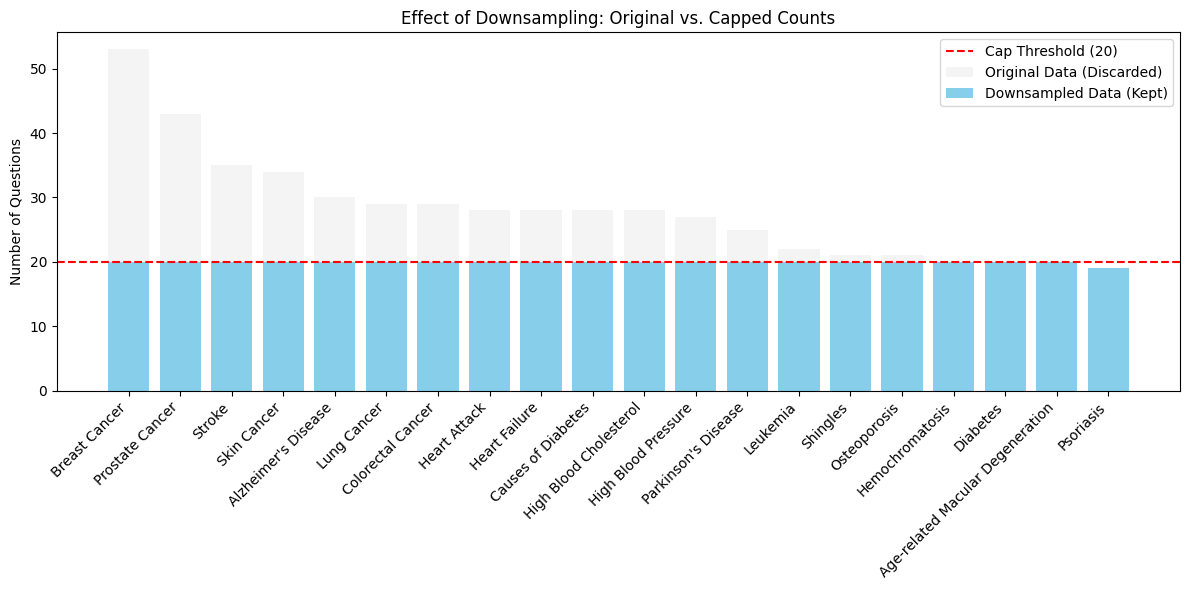

In [14]:
sampled_counts = df['focus_area'].value_counts()

# Select top 20 focus areas from the ORIGINAL data to visualize
top_areas = focus_area_counts.head(20).index

# Align both datasets to these top 20
original_vals = focus_area_counts.loc[top_areas]
sampled_vals = sampled_counts.reindex(top_areas, fill_value=0)

plt.figure(figsize=(12, 6))

# Plot Original Data (The "Shadow")
plt.bar(top_areas, original_vals, color='gainsboro', alpha=0.3, label='Original Data (Discarded)')

# Plot Sampled Data (The "Result")
plt.bar(top_areas, sampled_vals, color='skyblue', alpha=1.0, label='Downsampled Data (Kept)')

plt.axhline(y=20, color='red', linestyle='--', label='Cap Threshold (20)')

plt.xticks(rotation=45, ha = 'right', fontsize = 10)
plt.title('Effect of Downsampling: Original vs. Capped Counts')
plt.ylabel('Number of Questions')
plt.legend()
plt.tight_layout()
plt.show()

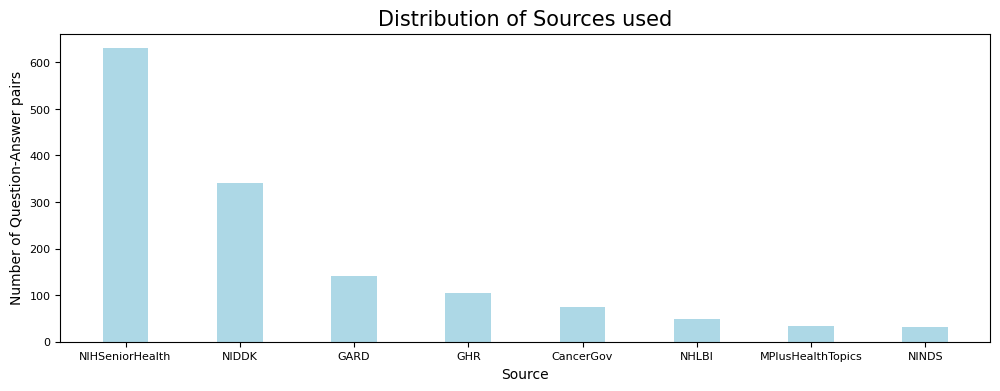

8 Sources used:  ['CancerGov', 'GARD', 'GHR', 'MPlusHealthTopics', 'NHLBI', 'NIDDK', 'NIHSeniorHealth', 'NINDS']


In [15]:
# After downsampling
# Bar Chart
source_counts = df['source'].value_counts()

plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 8})
plt.bar(source_counts.index, source_counts.values, color='lightblue', width=0.4)
plt.xlabel("Source", fontsize=10)
plt.ylabel("Number of Question-Answer pairs", fontsize=10)
plt.title("Distribution of Sources used", fontsize=15)
plt.show()

# Unique 'source's
unique_sources = df['source'].unique()
print(len(unique_sources), "Sources used: ", sorted(unique_sources))

### d. Length Distributions

In [16]:
word_count_question = df['question'].apply(lambda x: len(x.split(' ')) + 1)
word_count_answer = df['answer'].apply(lambda x: len(str(x).split(' ')) + 1)

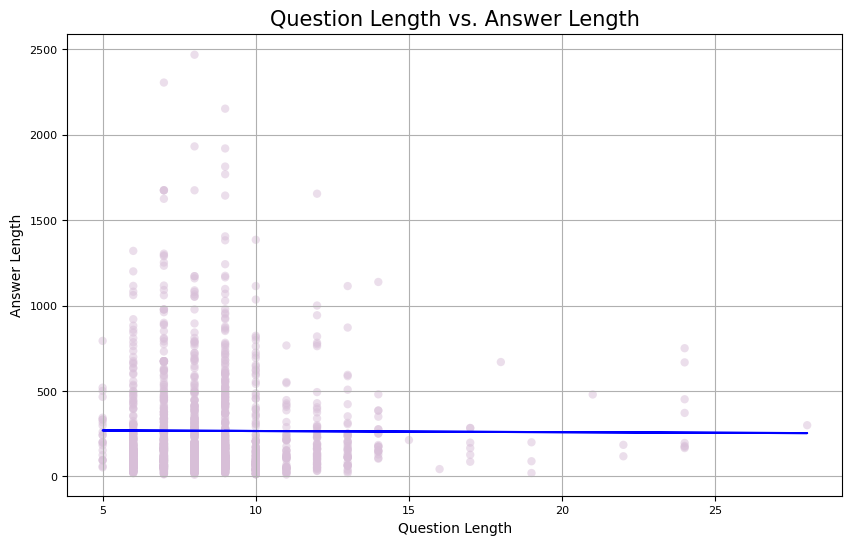

The gradient of the straight line is: -0.6824


In [17]:
# QA correlation
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(word_count_question, word_count_answer, alpha=0.5, edgecolors='none', color='thistle')

# Calculate equation for trendline
z = np.polyfit(word_count_question, word_count_answer, 1)
p = np.poly1d(z)
ax.plot(word_count_question, p(word_count_question), color='blue')

ax.set_xlabel('Question Length', fontsize=10)
ax.set_ylabel('Answer Length', fontsize=10)
ax.set_title('Question Length vs. Answer Length', fontsize=15)

ax.grid(True)
plt.show()

z = np.polyfit(word_count_question, word_count_answer, 1)
print(f"The gradient of the straight line is: {z[0]:.4f}")

Every 1-word increase in *Question length*, increases *Answer length* by ~1 word.

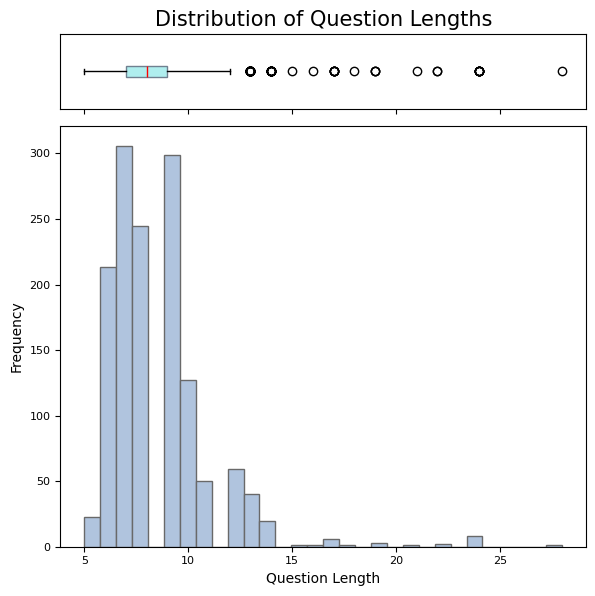

In [18]:
# Question Lengths
# 1. Box plot
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(6, 6))

ax_box.boxplot(word_count_question, vert=False, patch_artist=True,
               boxprops=dict(facecolor='paleturquoise', color='slategray'),
               medianprops=dict(color='red'))
ax_box.set_ylabel('')
ax_box.set_yticks([])
ax_box.set_title('Distribution of Question Lengths', fontsize=15)

# 2. Histogram on the bottom subplot
ax_hist.hist(word_count_question, bins=30, color='lightsteelblue', edgecolor='dimgrey')
ax_hist.set_xlabel('Question Length', fontsize=10)
ax_hist.set_ylabel('Frequency', fontsize=10)

fig.tight_layout() # Remove extra space between subplots
ax_box.set(xlabel='') # Remove x axis name for the boxplot
plt.show()

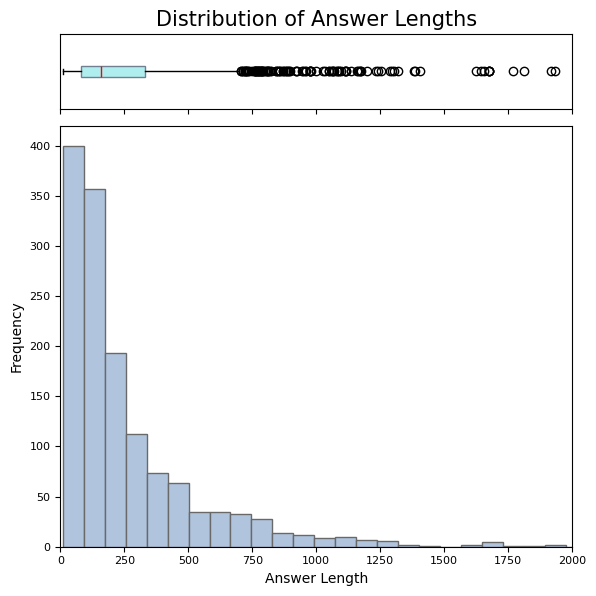

In [19]:
# Answer Lengths
# 1. Box plot
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(6, 6))

ax_box.boxplot(word_count_answer, vert=False, patch_artist=True,
               boxprops=dict(facecolor='paleturquoise', color='slategray'),
               medianprops=dict(color='red'))
ax_box.set_ylabel('')
ax_box.set_yticks([])
ax_box.set_title('Distribution of Answer Lengths', fontsize=15)

# 2. Histogram on the bottom subplot
ax_hist.hist(word_count_answer, bins=30, color='lightsteelblue', edgecolor='dimgrey')
ax_hist.set_xlabel('Answer Length', fontsize=10)
ax_hist.set_ylabel('Frequency', fontsize=10)

ax_hist.set_xlim(0,2000)

fig.tight_layout() # Remove extra space between subplots
ax_box.set(xlabel='') # Remove x axis name for the boxplot
plt.show()

## **1.2 Prepare the data**



### a. Duplicates - part 1

Set up needed functions

In [20]:
def normalize_text(text):
    """Normalize text for duplicate detection by removing spaces and punctuation.
    Returns: str"""
    if not isinstance(text, str): return ""

    text = text.lower() # Lowercase
    text = re.sub(r'\s+', ' ', text) # Remove all extra whitespace (spaces, tabs, newlines)
    text = text.strip() # Remove leading/trailing spaces

    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text

def hashing(df):
    """Create hash for Q&A pairs to detect duplicates.
    Returns: DataFrame"""
    # Normalize for Q and A fields using earlier 'normalize_text' function
    q_norm = df['question'].apply(normalize_text)
    a_norm = df['answer'].apply(normalize_text)

    # Combine normalized Q&A
    qa_norm = q_norm + '|||' + a_norm

    # Create 16 digit hash
    df['qa_hash'] = qa_norm.apply(lambda x: md5(x.encode()).hexdigest())

    return df

def identify_duplicates(df):
    """Search for duplicate hashes in the dataframe.
    Returns: tuple (hashes, DataFrame)"""
    qa_hash = df['qa_hash']

    # Find which hashes appear more than once
    hash_counts = qa_hash.value_counts()
    d_hashes = hash_counts[hash_counts > 1].index

    print(f"Of {len(df)} pairs, {qa_hash.nunique()} unique hashes were created")
    print(f"Duplicate groups found: {len(d_hashes)}")
    print(f"Total duplicate pairs: {hash_counts[d_hashes].sum()}")

    # Create d_df to store duplicated pairs
    d_df = df[qa_hash.isin(d_hashes)].copy()

    # Group duplicates using ids
    hash_groups = {hash_val: i for i, hash_val in enumerate(d_hashes)}
    d_df['duplicate group'] = d_df['qa_hash'].map(hash_groups)
    d_df = d_df.sort_values('duplicate group')

    return d_hashes, d_df

def remove_duplicates(df):
    """Remove duplicate Q&A pairs from dataframe.
    Returns: tuple (clean_df, duplicates_df)"""
    d_hashes, d_df = identify_duplicates(df)

    # Remove duplicates
    clean_df = df.drop_duplicates(subset = 'qa_hash', keep = 'first').copy()

    # Remove temporary fields
    clean_df = clean_df.drop(['qa_hash'], axis=1)
    d_df = d_df.drop(['qa_hash'], axis=1)

    print(f"After removing duplicates: {len(clean_df)} pairs")
    print(f"Removed: {len(df) - len(clean_df)} pairs\n")

    return clean_df, d_df

def truncate(text, length_limit):
    """Truncate text to specified character limit.
    Returns: str"""
    return f"{text[:length_limit]}{'...' if len(text) > length_limit else ''}"

def show_duplicates(df, max_groups = 10):
    """Display grouped duplicate Q&A pairs.
    Returns: None"""
    clean_df, d_df = remove_duplicates(df)

    if d_df is None:
        print("No duplicates found")
        return
    d_groups = d_df.groupby('duplicate group')
    print(f"{' '*21} Showing {max_groups} duplicate groups")
    d_pairs = list(d_groups)[:max_groups]
    for i, g in d_pairs:
        print(f"{'='*70}")
        print(f"{' '*22} GROUP {i+1} with {len(g)} occurrences")
        print(f"{'='*70}")

        p_ids = []
        for index, (pair_idx, pair) in enumerate(g.iterrows(),1):
            p_ids.append(f"Row {pair_idx}")
        print(", ". join(p_ids))

        pair = g.iloc[0]
        print("The duplicated QA pair")
        print(f"    Question: {truncate(pair['question'], 100)}")
        print(f"    Answer  : {truncate(pair['answer'], 60)}")
        print(f"    Focus Area: {pair['focus_area']}")

### b. Duplicates - part 2

duplicates in answer field

In [21]:
# Hash Q&A pairs
df = hashing(df)

# Review found duplicates
show_duplicates(df, max_groups = 10)

Of 1406 pairs, 1377 unique hashes were created
Duplicate groups found: 20
Total duplicate pairs: 49
After removing duplicates: 1377 pairs
Removed: 29 pairs

                      Showing 10 duplicate groups
                       GROUP 1 with 7 occurrences
Row 16020, Row 16210, Row 16209, Row 15347, Row 16019, Row 15248, Row 15346
The duplicated QA pair
    Question: What causes Causes of Diabetes ?
    Answer  : Other types of diabetes have a variety of possible causes. G...
    Focus Area: Causes of Diabetes
                       GROUP 2 with 4 occurrences
Row 15249, Row 16021, Row 15348, Row 16211
The duplicated QA pair
    Question: What to do for Causes of Diabetes ?
    Answer  : - Diabetes is a complex group of diseases with a variety of ...
    Focus Area: Causes of Diabetes
                       GROUP 3 with 3 occurrences
Row 15244, Row 16206, Row 15343
The duplicated QA pair
    Question: What causes Causes of Diabetes ?
    Answer  : Type 1 diabetes is caused by a lack of 

In [22]:
# Remove duplicates
clean_df, d_df = remove_duplicates(df)

Of 1406 pairs, 1377 unique hashes were created
Duplicate groups found: 20
Total duplicate pairs: 49
After removing duplicates: 1377 pairs
Removed: 29 pairs



In [23]:
# Check for exact duplicates for 'questions'
duplicates = clean_df[clean_df.duplicated(subset=['question'], keep=False)]
print(f"Found {len(duplicates)} rows with duplicate questions")
print(duplicates[['question', 'focus_area', 'source']].head(10))

# Remove duplicates before splitting
df_deduped = clean_df.drop_duplicates(subset=['question'], keep='first')
print(f"Removed {len(clean_df) - len(df_deduped)} duplicate questions")

Found 1008 rows with duplicate questions
                                               question     focus_area  \
771            What are the symptoms of Breast Cancer ?  Breast Cancer   
382                 Who is at risk for Breast Cancer? ?  Breast Cancer   
1165  what research (or clinical trials) is being do...  Breast Cancer   
772                     How to diagnose Breast Cancer ?  Breast Cancer   
1160           What are the symptoms of Breast Cancer ?  Breast Cancer   
775         What are the treatments for Breast Cancer ?  Breast Cancer   
399   what research (or clinical trials) is being do...  Breast Cancer   
390                 Who is at risk for Breast Cancer? ?  Breast Cancer   
383                     How to diagnose Breast Cancer ?  Breast Cancer   
401         What are the treatments for Breast Cancer ?  Breast Cancer   

               source  
771         CancerGov  
382   NIHSeniorHealth  
1165        CancerGov  
772         CancerGov  
1160        CancerGov  


In [24]:
df = df_deduped
# Reset index
df = df.reset_index(drop=True)

In [25]:
# Check for exact duplicates for 'questions'
duplicates = df[df.duplicated(subset=['question'], keep=False)]
print(f"Found {len(duplicates)} rows with duplicate questions")
print(duplicates[['question', 'focus_area', 'source']].head(10))

Found 0 rows with duplicate questions
Empty DataFrame
Columns: [question, focus_area, source]
Index: []


One of the primary advantages of using cryptographic hashing in data deduplication is its ability to quickly determine unique data segments. By generating a hash for each piece of data, systems can compare hash values rather than the actual data. If two data segments produce the same hash, they can be identified as duplicates. This method significantly reduces the time and resources required for data comparison, as comparing hash values is computationally less intensive than comparing full data sets.

### c. Clean `answer` field

In [26]:
def clean_references(text):
    """Remove references, contact info, irrelevant sentences, and unnecessary punctuation.
    Keep only periods, commas, apostrophes, and question marks.
    Returns: str(cleaned_text)"""
    if not isinstance(text, str):
        return ""

    # lowercasing
    text = text.lower()

    phone_pattern = r'\b\d{3}-\d{3}-\d{4}\b|\b\d{3}-\d{2}-\d{4}\b|\b1-\d{3}-\d{3}-\d{4}\b|\b\d{4}-\d{3}-\d{4}\b|\bToll Free:.*?\b'
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    address_pattern = r'\d+\s+[A-Za-z\s]+,\s*[A-Za-z\s]+,\s*[A-Z]{2}\s*\d{5}(-\d{4})?'

    # remove patterns
    text = re.sub(phone_pattern, '', text, flags=re.IGNORECASE)
    text = re.sub(email_pattern, '', text)
    text = re.sub(url_pattern, '', text)
    text = re.sub(address_pattern, '', text)

    irrelevant_keywords = [
        # Contact Information
        'toll free', 'toll-free', 'phone', 'email', 'fax', 'tty',
        # Navigation/Information Seeking
        'for more information', 'learn more', 'www', 'click', 'visit', 'call',
        'website', 'websites', 'see also', 'read more', 'see the pronunciation',
        # Publication/Document Elements
        'clearinghouse', 'esc', 'keyboard', 'video', 'glossary', 'chapter',
        'section', 'version', 'copyright', 'download', 'archived',
        # Specific Organizations
        'nci', 'niddk', 'national institute', 'american journal'
    ]

    # Split by sentence-ending punctuation followed by space
    sentences = re.split(r'(?<=[.!?])\s+', text)

    # if sentence has no irrelevant_keywords, then save to cleaned_sentences
    cleaned_sentences = [s for s in sentences if not any(keyword in s.lower() for keyword in irrelevant_keywords)]

    # Smart join: only add '. ' if previous sentence doesn't already end with punctuation
    cleaned_text = ""
    for i, sentence in enumerate(cleaned_sentences):
        if i == 0:
            cleaned_text = sentence
        else:
            # Only add '. ' if the previous part doesn't end with . or ?
            if cleaned_text and not cleaned_text.endswith(('.', '?')):
                cleaned_text += '. '
            else:
                cleaned_text += ' '
            cleaned_text += sentence

    cleaned_text = cleaned_text.strip()

    # Replace whitespace characters with a single space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

    # If sentence starts with . then remove the .
    cleaned_text = re.sub(r'^\s*\.\s*', '', cleaned_text)

    # Keep ONLY periods, commas, apostrophes, question marks - remove ALL other punctuation
    allowed_punct = {'.', ',', "'", '?'}
    text_minimal_punct = ""
    for char in cleaned_text:
        if char.isalnum() or char.isspace() or char in allowed_punct:
            text_minimal_punct += char

    # Clean up spacing again after punctuation removal
    cleaned_text = ' '.join(text_minimal_punct.split()).strip()

    # Ensure text ends with period only if it doesn't already end with . or ?
    if cleaned_text and not cleaned_text.endswith(('.', '?')):
        cleaned_text += '.'

    return cleaned_text

df_answer = df['answer'].apply(clean_references)

In [27]:
print("Before: ", df['answer'][510])
print("After: ", df_answer[510])
df['answer'] = df_answer
# Remove rows where the answer field is empty or only whitespace
df = df[df['answer'].str.strip() != '']

# Reset index
df = df.reset_index(drop=True)

Before:  Dannon disease is inherited in an X-linked fashion. Click here to visit the Centre for Genetics Education Web site to learn more about X linked inheritance.
After:  dannon disease is inherited in an xlinked fashion.


In [28]:
df.shape

(706, 4)

In [29]:
# After cleaning, Run the function on the sample DataFrame
summary_df = get_column_stats(df)

print("---------------- Column Stats Summary ----------------")
print(summary_df)
print("------------------------------------------------------")

---------------- Column Stats Summary ----------------
                   Type Min Length Max Length Average Length
question    String/Text         20        191      43.958924
answer      String/Text         40      13572    1441.536827
source      String/Text          3         17       8.378187
focus_area  String/Text          4        136      20.206799
------------------------------------------------------


### d. Split datasets for fine-tuning and testing



to be then train and validate the LLM

In [30]:
# 1. Outer Split: Train (70%) vs Val+Test (30%)
gss_outer = GroupShuffleSplit(n_splits=1, test_size = 0.30, random_state = 1)
train_idx, valtest_idx = next(gss_outer.split(df, groups = df['question']))

train_data = df.iloc[train_idx].copy()
valtest_df = df.iloc[valtest_idx].copy()

# 2. Inner Split: Val (20%) vs Test (10%)
gss_inner = GroupShuffleSplit(n_splits = 1, test_size=1/3, random_state=  1)
val_idx, test_idx = next(gss_inner.split(valtest_df, groups=valtest_df['question']))

val_data = valtest_df.iloc[val_idx].copy()
test_data = valtest_df.iloc[test_idx].copy()

# Check sizes
print(f"Train size: {len(train_data)}")
print(f"Val size:   {len(val_data)}")
print(f"Test size:  {len(test_data)}")

# Check for Leakage
train_qs = set(train_data['question'])
test_qs = set(test_data['question'])
overlap = train_qs.intersection(test_qs)
print(f"Question Leakage: {len(overlap)} (should be 0)")

Train size: 494
Val size:   141
Test size:  71
Question Leakage: 0 (should be 0)


In [31]:
print("------------------------------ Check for Data Leakage -----------------------------")
# 1. ID / Source Leakage
train_ids = set(train_data['question_id']) if 'question_id' in train_data else set(train_data.index)
test_ids = set(test_data['question_id']) if 'question_id' in test_data else set(test_data.index)

id_overlap = train_ids.intersection(test_ids)
print(f"1. ID Overlap: {len(id_overlap)} IDs found in both sets.")
if len(id_overlap) > 0:
    print(f"   CRITICAL: Remove IDs {list(id_overlap)[:5]}...")

# 2. Look for questions in Test that are  copies of questions in Train
train_questions = set(train_data['question'].str.lower().str.strip())
test_questions = set(test_data['question'].str.lower().str.strip())

q_overlap = train_questions.intersection(test_questions)

print(f"\n2. Question Text Overlap: {len(q_overlap)} unique questions found in both sets.")
print(f"   Test Set Size: {len(test_questions)} unique questions")

leakage_pct = len(q_overlap) / len(test_questions) * 100
print(f"   {leakage_pct:.1f}% of your Test Set questions are repeats of Training questions.")

if len(q_overlap) > 0:
    print(f"   Example: '{list(q_overlap)[0]}'")

# 3. Check if the Test Answer text exists inside the Training Question OR Answer columns
train_answers = set(train_data['answer'].str.lower().str.strip())
test_answers = set(test_data['answer'].str.lower().str.strip())

a_overlap = train_answers.intersection(test_answers)
print(f"\n3. Answer Text Overlap: {len(a_overlap)} exact answers found in both sets.")

if len(a_overlap) > 0:
    print("   Test set contains answers that are identical to Training answers.")
    print("   The model might just retrieve the text rather than generating it.")
print("-----------------------------------------------------------------------------------")

------------------------------ Check for Data Leakage -----------------------------
1. ID Overlap: 0 IDs found in both sets.

2. Question Text Overlap: 0 unique questions found in both sets.
   Test Set Size: 71 unique questions
   0.0% of your Test Set questions are repeats of Training questions.

3. Answer Text Overlap: 1 exact answers found in both sets.
   Test set contains answers that are identical to Training answers.
   The model might just retrieve the text rather than generating it.
-----------------------------------------------------------------------------------


In [32]:
for a in a_overlap:print(a, "\n")

this condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. 



In [33]:
print(f"Original Test Data size: {len(test_data)} rows")

test_answers_normalized = test_data['answer'].str.lower().str.strip()
test_df_cleaned = test_data[~test_answers_normalized.isin(a_overlap)].copy()
test_data = test_df_cleaned

print(f"Test Data size after removing answer overlap: {len(test_data)} rows")

print("\n------------------------------ Re-run Data Leakage Check -----------------------------")
test_questions = set(test_data['question'].str.lower().str.strip())
test_answers = set(test_data['answer'].str.lower().str.strip())

q_overlap = train_questions.intersection(test_questions)
a_overlap_cleaned = train_answers.intersection(test_answers)

print(f"1. Question Text Overlap: {len(q_overlap)} unique questions found in both sets.")
print(f"   Test Set Size: {len(test_questions)} unique questions")
leakage_q_pct = len(q_overlap) / len(test_questions) * 100
print(f"   {leakage_q_pct:.1f}% of your Test Set questions are repeats of Training questions.")

print(f"\n2. Answer Text Overlap (after cleaning): {len(a_overlap_cleaned)} exact answers found in both sets.")
if len(a_overlap_cleaned) == 0:
    print("   No exact answer overlaps remaining.")
else:
    print("   Still some overlaps")
print("-----------------------------------------------------------------------------------")

Original Test Data size: 71 rows
Test Data size after removing answer overlap: 70 rows

------------------------------ Re-run Data Leakage Check -----------------------------
1. Question Text Overlap: 0 unique questions found in both sets.
   Test Set Size: 70 unique questions
   0.0% of your Test Set questions are repeats of Training questions.

2. Answer Text Overlap (after cleaning): 0 exact answers found in both sets.
   No exact answer overlaps remaining.
-----------------------------------------------------------------------------------


In [34]:
# Get unique Focus Areas for each split
train_areas = set(train_data['focus_area'].unique())
val_areas = set(val_data['focus_area'].unique())
test_areas = set(test_data['focus_area'].unique())

# Print detailed statistics
print("-----------------focus_area overlap analysis-----------------")
print(f"Unique areas in Train: {len(train_areas)}")
print(f"Unique areas in Val:   {len(val_areas)}")
print(f"Unique areas in Test:  {len(test_areas)}")

common_to_all = train_areas.intersection(val_areas).intersection(test_areas)
print(f"\nAreas common to ALL THREE splits: {len(common_to_all)}")

missing_from_test = train_areas - test_areas
if len(missing_from_test) == 0:
    print("Every topic in Train is also in Test, which is wrong")
else:
    print(f"{len(missing_from_test)} topics in Train are missing from Test, which is fine")
    train_only = train_areas - test_areas
    if len(train_only) > 0:
        print("Missing Examples:", list(train_only)[:5])
    print()
unique_to_test = test_areas - train_areas - val_areas
if len(unique_to_test) > 0:print(f"{len(unique_to_test)} topics appear ONLY in Test")
print("-------------------------------------------------------------")

-----------------focus_area overlap analysis-----------------
Unique areas in Train: 101
Unique areas in Val:   75
Unique areas in Test:  52

Areas common to ALL THREE splits: 38
49 topics in Train are missing from Test, which is fine
Missing Examples: ['Leukemia', 'Psoriasis', 'COPD', 'High Blood Pressure', 'Diabetes']

-------------------------------------------------------------


In [35]:
print("focus_area unique to each split")
unique_to_train = train_areas - val_areas - test_areas
print(f"Train: {unique_to_train}")
unique_to_val = val_areas - train_areas - test_areas
print(f"Val:   {unique_to_val}")
print(f"Test:  {unique_to_test}")

focus_area unique to each split
Train: {'Leukemia', 'Prostate Cancer', 'Knee Replacement', 'Nutrition for Advanced Chronic Kidney Disease in Adults', 'Alcohol Use and Older Adults', 'Opitz G/BBB syndrome', 'Proctitis', 'Surviving Cancer', 'Kidney Failure: Eat Right to Feel Right on Hemodialysis', 'Cataract', "Alzheimer's Caregiving", 'Anxiety Disorders', 'Celiac Disease'}
Val:   {'Medicare and Continuing Care'}
Test:  set()


### e. Create chunks

In [36]:
# Calculate actual token counts
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
question_tokens = [len(tokenizer.encode(q)) for q in train_data['question']]
answer_tokens = [len(tokenizer.encode(a)) for a in train_data['answer'] ]

combined_tokens = [q + a for q, a in zip(question_tokens, answer_tokens)]

print("For Train data")
print(f"Avg question tokens: {sum(question_tokens)/len(question_tokens)}")
print(f"Avg answer tokens: {sum(answer_tokens)/len(answer_tokens)}")
print(f"Avg combined tokens: {sum(combined_tokens)/len(combined_tokens)}")
print(f"95th percentile answer tokens: {sorted(answer_tokens)[int(len(answer_tokens)*0.95)]}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (888 > 512). Running this sequence through the model will result in indexing errors


For Train data
Avg question tokens: 13.748987854251013
Avg answer tokens: 341.47975708502025
Avg combined tokens: 355.2287449392713
95th percentile answer tokens: 1094


In [37]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=350,
    chunk_overlap=50,
    length_function=lambda x: len(tokenizer.encode(x)),
)

# Get the longest answers by character length
longest_answers_train = train_data.assign(answer_len=train_data['answer'].str.len()).nlargest(3, 'answer_len')['answer'].tolist()
longest_answers_val = val_data.assign(answer_len=val_data['answer'].str.len()).nlargest(3, 'answer_len')['answer'].tolist()
longest_answers_test = test_data.assign(answer_len=test_data['answer'].str.len()).nlargest(3, 'answer_len')['answer'].tolist()

test_answers = longest_answers_train + longest_answers_val + longest_answers_test

token_lengths = []
for answer in test_answers:
    chunks = splitter.split_text(answer)
    for chunk in chunks:
        tokens = len(tokenizer.encode(chunk))
        token_lengths.append(tokens)
print(f"Total Chunks: {len(token_lengths)}")
print(f"Shortest Chunk: {min(token_lengths)} tokens")
print(f"Longest Chunk: {max(token_lengths)} tokens")
print(f"Average length: {sum(token_lengths)/len(token_lengths)}")
sorted_n = sorted(token_lengths)
n = len(sorted_n)
mid = n // 2
if n%2 == 0: print(f"Median length: {sorted_n[mid - 1]+sorted_n[mid]/2}")
else: print(f"Median length: {sorted_n[mid]}")

Total Chunks: 137
Shortest Chunk: 22 tokens
Longest Chunk: 175 tokens
Average length: 137.62773722627736
Median length: 140


In [38]:
def create_chunks(dataframe, split_subset, start_counter):
    """Split dataframe into chunks with sequential IDs.
    Returns: tuple (chunks_list, counter)"""
    local_chunks = []
    current_counter = start_counter
    for i, row in dataframe.iterrows():
        answer_text = row['answer']
        q, a_sliced, focus, source = row['question'], answer_text, row['focus_area'], row['source']
        chunks = splitter.split_text(a_sliced)

        for chunk_local_id, chunk in enumerate(chunks):
            local_chunks.append({
                'question_id': current_counter,                    # New sequential ID
                'chunk_id': f"{current_counter}_{chunk_local_id}", # Unique ID based on new sequential ID
                'question': q,                                     # Original question
                'chunk_answer': chunk,                             # The actual split text
                'focus_area': focus,
                'source': source,
                'split_subset': split_subset                       # Add split subset information
            })
        current_counter += 1            # Increment the counter after processing all chunks for a question
    return local_chunks, current_counter


current_question_id_counter = 0

train_chunks, current_question_id_counter = create_chunks(train_data, 'train', current_question_id_counter)
val_chunks, current_question_id_counter = create_chunks(val_data, 'val', current_question_id_counter)
test_chunks, current_question_id_counter = create_chunks(test_data, 'test', current_question_id_counter)

print(f"Total chunks created: {len(train_chunks)}")
print(f"Total unique question_ids: {current_question_id_counter}")

# Calculate token counts
chunk_token_counts = [len(tokenizer.encode(chunk['chunk_answer'])) for chunk in train_chunks]
print(f"Post-chunking avg tokens: {sum(chunk_token_counts)/len(chunk_token_counts):.2f}")
print(f"Post-chunking 95th percentile: {sorted(chunk_token_counts)[int(len(chunk_token_counts)*0.95)]}")

Total chunks created: 1535
Total unique question_ids: 705
Post-chunking avg tokens: 124.30
Post-chunking 95th percentile: 160


### f. Create embeddings on `train_data`

convert each chunk into dense vector embeddings using `SentenceTransformer` model

In [39]:
qa_pairs = []

for chunk_item in train_chunks:
    question = chunk_item.get('question', '')
    chunk_answer = chunk_item.get('chunk_answer', '')

    # Embedding qa_pairs
    qa_pairs.append(f"{question} {chunk_answer}")

embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Create embeddings
embeddings = embed_model.encode(
    qa_pairs,
    batch_size = 64,
    show_progress_bar = True,
    convert_to_numpy = True,
    normalize_embeddings = True
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

### g. Chromadb vector store for `train_data`

In [40]:
# Initialize ChromaDB
db_client = chromadb.PersistentClient(path="./MedQuAD_db")

# In case of duplicates from re-runs
try:
    db_client.delete_collection("medical_rag")
except:
    pass

vector_store = db_client.create_collection(name="medical_rag")

# Add to ChromaDB
vector_store.add(
    ids = [m['chunk_id'] for m in train_chunks],  # Use chunk_id as primary key
    embeddings = embeddings.tolist(),
    documents = qa_pairs,
    metadatas = train_chunks                      # Previously defined
)

In [41]:
qa_pairs = []

for chunk_item in train_chunks:
    question = chunk_item.get('question', '')
    chunk_answer = chunk_item.get('chunk_answer', '')

    # Embedding qa_pairs
    qa_pairs.append(f"{question} {chunk_answer}")

embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Create embeddings
embeddings = embed_model.encode(
    qa_pairs,
    batch_size = 64,
    show_progress_bar = True,
    convert_to_numpy = True,
    normalize_embeddings = True
)

# Initialize ChromaDB
db_client = chromadb.PersistentClient(path="./MedQuAD_db")

# In case of duplicates from re-runs
try:
    db_client.delete_collection("medical_rag")
except:
    pass

vector_store = db_client.create_collection(name="medical_rag")

# Add to ChromaDB
vector_store.add(
    ids = [m['chunk_id'] for m in train_chunks],  # Use chunk_id as primary key
    embeddings = embeddings.tolist(),
    documents = qa_pairs,
    metadatas = train_chunks                      # Previously defined
)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [42]:
print("=" * 33, "qa_pairs[0]", "=" * 33)
pprint(qa_pairs[0])
print("\n", "=" * 31, "train_chunks[0]", "=" * 31)
pprint(train_chunks[0])
print("\n", "=" * 23, "vector_store.get(ids = ['0_0'])", "=" * 24)
vector_store.get(ids = ['0_0'])

================================= qa_pairs[0] =================================
('What are the symptoms of Breast Cancer ? signs of breast cancer include a '
 'lump or change in the breast. these and other signs may be caused by breast '
 'cancer or by other conditions. check with your doctor if you have any of the '
 'following a lump or thickening in or near the breast or in the underarm '
 'area. a change in the size or shape of the breast. a dimple or puckering in '
 'the skin of the breast. a nipple turned inward into the breast. fluid, other '
 "than breast milk, from the nipple, especially if it's bloody. scaly, red, or "
 'swollen skin on the breast, nipple, or')

 =============================== train_chunks[0] ===============================
{'chunk_answer': 'signs of breast cancer include a lump or change in the '
                 'breast. these and other signs may be caused by breast cancer '
                 'or by other conditions. check with your doctor if you have '
   

{'ids': ['0_0'],
 'embeddings': None,
 'documents': ["What are the symptoms of Breast Cancer ? signs of breast cancer include a lump or change in the breast. these and other signs may be caused by breast cancer or by other conditions. check with your doctor if you have any of the following a lump or thickening in or near the breast or in the underarm area. a change in the size or shape of the breast. a dimple or puckering in the skin of the breast. a nipple turned inward into the breast. fluid, other than breast milk, from the nipple, especially if it's bloody. scaly, red, or swollen skin on the breast, nipple, or"],
 'uris': None,
 'included': ['metadatas', 'documents'],
 'data': None,
 'metadatas': [{'source': 'CancerGov',
   'split_subset': 'train',
   'question': 'What are the symptoms of Breast Cancer ?',
   'question_id': 0,
   'focus_area': 'Breast Cancer',
   'chunk_answer': "signs of breast cancer include a lump or change in the breast. these and other signs may be caused by b

In [43]:
# Query ChromaDB
results = vector_store.query(
    query_texts = ["What is (are) Glaucoma ?"],
    n_results = 5
)

# Check id consistency
for i, (chunk_id, m) in enumerate(zip(results['ids'][0], results['metadatas'][0])):
    print(f"Result {i}:")
    print(f"  chunk_id: {chunk_id}")
    print(f"  question_id: {m['question_id']}")
    print(f"  question: {m['question']}")
    print(f"  split: {m['split_subset']}")
    print(f"  Can trace back: question_id {m['question_id']} → original train_data row\n")

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:03<00:00, 23.9MiB/s]


Result 0:
  chunk_id: 130_1
  question_id: 130
  question: What are the treatments for Glaucoma ?
  split: train
  Can trace back: question_id 130 → original train_data row

Result 1:
  chunk_id: 130_0
  question_id: 130
  question: What are the treatments for Glaucoma ?
  split: train
  Can trace back: question_id 130 → original train_data row

Result 2:
  chunk_id: 130_2
  question_id: 130
  question: What are the treatments for Glaucoma ?
  split: train
  Can trace back: question_id 130 → original train_data row

Result 3:
  chunk_id: 129_0
  question_id: 129
  question: What are the symptoms of Glaucoma ?
  split: train
  Can trace back: question_id 129 → original train_data row

Result 4:
  chunk_id: 111_0
  question_id: 111
  question: What is (are) Cataract ?
  split: train
  Can trace back: question_id 111 → original train_data row



# **2. Implement a Retrieval-Augmented Generation (RAG):**

## **2.1 Retriever**

### a. Rewrite query

Below is an instruction that describes a task, paired with an inpu that provides further context. Write a response that appropriately completes the request. Instruction: {You are a helpful medical practitioner}
Input:
{}
Response:
{}

In [44]:
rewritter_llm = pipeline(
    "text2text-generation",
    model = "google/flan-t5-small",
    max_length = 64,
    do_sample = False,        # always chooses the most probable next word or token
    temperature = 0.3,        # more straightforward and predictable output
    repetition_penalty = 1.3, # minimize repetition and have a more varied output
    no_repeat_ngram_size = 2)

def rewrite_query(user_query):
    """Rewrite user query to be more specific and medical-focused.
    Returns: str"""

    # few shot prompting
    prompt = f"""Rewrite the input into a clear medical question following these patterns
    Input: my head hurts
    Output: What causes headaches?

    Input: i keep vomiting but feel ok afterwards
    Output: What causes cyclic vomiting?

    Input: chest pain when breathing
    Output: What causes chest pain during breathing?

    Input: {user_query}
    Output:
    """

    llm_output = rewritter_llm(prompt)

    rewritten_query = llm_output[0]['generated_text']
    rewritten_query = rewritten_query.replace("Output:", "").strip()

    return rewritten_query.strip()

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [45]:
# test
user_query = "What are the symptoms of Cyclic Vomiting Syndrome ?"
rewritten_query = rewrite_query(user_query)

print(f"Original: {user_query}")
print(f"Rewritten: {rewritten_query}")

Original: What are the symptoms of Cyclic Vomiting Syndrome ?
Rewritten: What are the symptoms of Cyclic Vomiting Syndrome?


### b. Re-rank Contexts

In [46]:
rerank_tokenizer = AutoTokenizer.from_pretrained("castorini/monot5-base-msmarco")
rerank_model = AutoModelForSeq2SeqLM.from_pretrained("castorini/monot5-base-msmarco")
rerank_model.eval() # Set to evaluation mode, w/o training

tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [47]:
def getMonoT5Scores(rewritten_query, chunks):
  """Calculate relevance scores for chunks against query.
  Returns: list"""
  # 1. Format the input "Query: ABC? Document: XYZ... Relevant: "
  inputs = [f"Query: {rewritten_query} Document: {c} Relevant:" for c in chunks]

  # 2. Tokenise
  tokenized_inputs = rerank_tokenizer(
      inputs,
      padding = True,
      truncation = True,      # Cut off if chunk is too long
      return_tensors = 'pt')  # Return as PyTorch tensors

  # 2. Generate predictions either True / False
  with torch.no_grad():                                       # w/o calculating gradients, and faster
    outputs = rerank_model.generate(
        input_ids = tokenized_inputs['input_ids'],
        attention_mask = tokenized_inputs['attention_mask'],
        max_new_tokens = 1,                                   # Only generate 1 token ("true" or "false")
        return_dict_in_generate = True,
        output_scores = True)                                 # Get probability scores, not just the token

    # 3. Extract scores
    true_token_id = rerank_tokenizer.encode("true")[0]
    batch_scores = outputs.scores[0][:, true_token_id]        # Get probability of "true"

    return batch_scores.tolist()

### c. final `retriever` function *(and versions)*

In [48]:
def retriever(q, top_k = 3, detail = False):
    """Retrieve relevant context chunks for a query.
    Returns: list(contexts) or list(list(contexts)) if q is a list of queries
    """

    is_single_query = isinstance(q, str)
    queries = [q] if is_single_query else q

    q_embeddings = embed_model.encode(queries).tolist()

    search_results = vector_store.query(
        query_embeddings = q_embeddings,
        n_results = 10
    )

    all_contexts = []

    for i in range(len(queries)):
        contexts_for_query = []
        if search_results['documents'][i]:
            for r in range(len(search_results['ids'][i])):
                item = {
                    'chunk_id': search_results['ids'][i][r],
                    'chunk_answer': search_results['documents'][i][r],
                    'question': search_results['metadatas'][i][r]['question']
                }
                if detail:
                    item['focus_area'] = search_results['metadatas'][i][r].get('focus_area', 'Unknown')
                    item['source'] = search_results['metadatas'][i][r].get('source', 'Unknown')
                    item['chroma_distance'] = round(search_results['distances'][i][r], 3)
                contexts_for_query.append(item)
        all_contexts.append(contexts_for_query)

    if is_single_query:
        return all_contexts[0]
    else:
        return all_contexts

In [49]:
def retrieverWithoutRewriter(q, top_k = 3, detail = False):
    """Retrieve relevant context chunks for a query with reranking but without rewriting.
    Returns: list(contexts) or list(list(contexts)) if q is a list of queries
    """

    is_single_query = isinstance(q, str)
    queries = [q] if is_single_query else q

    q_embeddings = embed_model.encode(queries).tolist()

    search_results = vector_store.query(
        query_embeddings = q_embeddings,
        n_results = 10
    )

    all_contexts = []

    for i in range(len(queries)):
        contexts_for_query = []
        if search_results['documents'][i]:
            retrieved_chunks = search_results['documents'][i]
            retrieved_metas = search_results['metadatas'][i]
            retrieved_ids = search_results['ids'][i]
            retrieved_distances = search_results.get('distances', [[]])[i]

            rerank_scores = getMonoT5Scores(queries[i], retrieved_chunks)
            if len(rerank_scores) != len(retrieved_chunks):
                print(f"Warning: Rerank scores mismatch chunk count for query '{queries[i]}'. Skipping reranking for this query.")
                candidates = []
                for r in range(len(retrieved_chunks)):
                    candidates.append({
                        'chunk_id': retrieved_ids[r],
                        'chunk_answer': retrieved_chunks[r],
                        'question': retrieved_metas[r]['question'],
                        'focus_area': retrieved_metas[r].get('focus_area', 'Unknown'),
                        'chroma_dist': retrieved_distances[r]
                    })
            else:
                candidates = []
                for r in range(len(retrieved_chunks)):
                    candidates.append({
                        'chunk_id': retrieved_ids[r],
                        'chunk_answer': retrieved_chunks[r],
                        'question': retrieved_metas[r]['question'],
                        'focus_area': retrieved_metas[r].get('focus_area', 'Unknown'),
                        'chroma_dist': retrieved_distances[r],
                        'rerank_score': rerank_scores[r]
                    })

                candidates.sort(key = lambda s:s['rerank_score'], reverse = True)

            sorted_results = candidates[:top_k]

            for item_dict in sorted_results:
                item = {
                    'chunk_id': item_dict['chunk_id'],
                    'chunk_answer': item_dict['chunk_answer'],
                    'question': item_dict['question']
                }
                if detail:
                    item['focus_area'] = item_dict['focus_area']
                    if 'rerank_score' in item_dict:
                        item['rerank_score'] = round(item_dict['rerank_score'], 3)
                    item['chroma_distance'] = round(item_dict['chroma_dist'], 3)
                contexts_for_query.append(item)
        all_contexts.append(contexts_for_query)

    if is_single_query:
        return all_contexts[0]
    else:
        return all_contexts

In [50]:
def retrieverWithoutReranker(q, top_k = 3, detail = False):
    """Retrieve relevant context chunks for a query with rewriting but without reranking.
    Returns: list(contexts) or list(list(contexts)) if q is a list of queries
    """

    is_single_query = isinstance(q, str)
    queries = [q] if is_single_query else q

    rewritten_queries = [rewrite_query(query) for query in queries]

    for i, q_rewritten in enumerate(rewritten_queries):
        if not q_rewritten or q_rewritten.strip() == "":
            raise ValueError(f"Query rewrite returned empty string for query: {queries[i]}")

    q_embeddings = embed_model.encode(rewritten_queries).tolist()

    search_results = vector_store.query(
        query_embeddings = q_embeddings,
        n_results = 10
    )

    all_contexts = []

    for i in range(len(queries)):
        contexts_for_query = []
        if search_results['documents'][i]:
            for r in range(len(search_results['ids'][i])):
                item = {
                    'chunk_id': search_results['ids'][i][r],
                    'chunk_answer': search_results['documents'][i][r],
                    'question': search_results['metadatas'][i][r]['question']
                }
                if detail:
                    item['focus_area'] = search_results['metadatas'][i][r].get('focus_area', 'Unknown')
                    item['source'] = search_results['metadatas'][i][r].get('source', 'Unknown')
                    item['chroma_distance'] = round(search_results['distances'][i][r], 3)
                contexts_for_query.append(item)
        all_contexts.append(contexts_for_query)

    if is_single_query:
        return all_contexts[0]
    else:
        return all_contexts

In [51]:
def retrieverWithRewriterReranker(q, top_k = 3, detail = False):
    """Retrieve relevant context chunks for a query with rewriting and reranking.
    Returns: list(contexts) or list(list(contexts)) if q is a list of queries
    """
    is_single_query = isinstance(q, str)
    queries = [q] if is_single_query else q

    all_contexts = []

    for query in queries:
        q_rewritten = rewrite_query(query)
        q_embed = embed_model.encode([q_rewritten]).tolist()
        if not q_rewritten or q_rewritten.strip() == "":
            raise ValueError("Query rewrite returned empty string")

        search_result = vector_store.query(
            query_embeddings = q_embed,
            n_results = 10)

        if not search_result['documents'][0]:
            all_contexts.append([])
            continue

        retrieved_chunks = search_result['documents'][0]
        retrieved_metas = search_result['metadatas'][0]
        retrieved_ids = search_result['ids'][0]
        retrieved_distances = search_result.get('distances', [[]])[0]

        rerank_scores = getMonoT5Scores(q_rewritten, retrieved_chunks)
        if len(rerank_scores) != len(retrieved_chunks):
            raise ValueError("Rerank scores mismatch chunk count")

        candidates = []
        for r in range(len(retrieved_chunks)):
            candidates.append({
                'chunk_id': retrieved_ids[r],
                'chunk_answer': retrieved_chunks[r],
                'question': retrieved_metas[r]['question'],
                'focus_area': retrieved_metas[r].get('focus_area', 'Unknown'),
                'chroma_dist': retrieved_distances[r],
                'rerank_score': rerank_scores[r]
            })

        candidates.sort(key = lambda s:s['rerank_score'], reverse = True)
        sorted_results = candidates[:top_k]

        contexts = []
        for i in sorted_results:
            item = {
                'chunk_id': i['chunk_id'],
                'chunk_answer': i['chunk_answer'],
                'question': i['question']
            }
            if detail:
                item['focus_area'] = i['focus_area']
                item['rerank_score'] = round(i['rerank_score'], 3)
                item['chroma_distance'] = round(i['chroma_dist'], 3)
            contexts.append(item)

        all_contexts.append(contexts)

    if is_single_query:
        return all_contexts[0]
    else:
        return all_contexts

## **2.2 Augmenter**

In [52]:
# load baseline model
flant5tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
flant5model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

### Build Prompt

In [53]:
def buildPrompt(user_query, context, rewritten_query, max_tokens = 512):
    """Build prompt with context and query within token limit.
    Returns: str(full prompt)"""

    if not context:
        return f"""No relevant medical information found.
Q: {rewritten_query}
A: Information unavailable."""

    instruction_text = "Medical Context:\n"
    query_footer = f"\nQ: {rewritten_query}\nA:"

    # Calculate "Static Overhead"
    inst_tokens = len(flant5tokenizer.encode(instruction_text, add_special_tokens=False))
    query_tokens = len(flant5tokenizer.encode(query_footer, add_special_tokens=False))
    total_static_cost = inst_tokens + query_tokens + 5

    # Calculate remaining budget for context
    remaining_tokens = max_tokens - total_static_cost

    if remaining_tokens < 0:
        remaining_tokens = 0

    # Fill the context budget
    valid_contexts = []
    current_context_tokens = 0

    for idx, c in enumerate(context, start=1):
        chunk_text = f"[C{idx}] {c['question']}\n{c['chunk_answer']}"
        chunk_len = len(flant5tokenizer.encode(chunk_text, add_special_tokens=False))

        if current_context_tokens + chunk_len > remaining_tokens:
            break

        valid_contexts.append(chunk_text)
        current_context_tokens += chunk_len

    the_context_block = "\n".join(valid_contexts)
    full_prompt = f"{instruction_text}{the_context_block}{query_footer}"

    return full_prompt

In [54]:
text_to_tokenize = "Instruction: Use the following medical contexts to answer the question directly, do not repeat the question.Contexts:[C1]Answer:"
token_count = len(flant5tokenizer.encode(text_to_tokenize, add_special_tokens=False))
print(f"The text has {token_count} tokens.")

The text has 33 tokens.


## **2.3 Fine Tuning** (only run if needed)

### a. Tokenize

*i.e. segment the `train` and `val` text into subwords or tokens, which the model then utilizes as input.*

In [ ]:
# --- Convert pandas DataFrame to Huggin Face Dataset object first
train_ds = Dataset.from_pandas(train_data)
val_ds = Dataset.from_pandas(val_data)

In [ ]:
def tokenise(examples):
    """Tokenize question and answer text for model training.
    Returns: dict(model_inputs)"""

    # Create input and target strings
    inputs =[]
    for fa, q in zip(examples['focus_area'], examples['question']):
        text = "Focus: " + fa + " Question: " + q
        inputs.append(text)

    # Append EOS token to every answer
    targets = [a + flant5tokenizer.eos_token for a in examples['answer']]

    # Tokenize inputs (questions + focus areas)
    model_inputs = flant5tokenizer(
        inputs,
        max_length = 1024,
        padding = False,
        truncation = True)

    # Tokenize targets (answers)
    model_labels = flant5tokenizer(
        targets,
        max_length = 128,
        padding = False,
        truncation = True)

    model_inputs["labels"] = model_labels["input_ids"]
    return model_inputs

tokenized_train = train_ds.map(tokenise, batched = True)
tokenized_val = val_ds.map(tokenise, batched = True)

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

Map:   0%|          | 0/141 [00:00<?, ? examples/s]

### b. Fine-tuning `google/flan-t5-small`

In [ ]:
collator = DataCollatorForSeq2Seq(
    tokenizer = flant5tokenizer,
    model = flant5model,
    label_pad_token_id = -100,  # model wont be pernalised for empty spaces
    pad_to_multiple_of = 8)     # Pads sequences to the same length

gen_config = GenerationConfig(
    max_new_tokens = 100,           # Caps the output length (prevents endless rambling)
    repetition_penalty = 1.2,       # Penalizes words that have already appeared (fixes loops)
    early_stopping = True,          # Stops generation immediately when the EOS token is found
    eos_token_id = flant5tokenizer.eos_token_id, # The specific ID that signals "The End"
    num_beams = 4                   # Generates 4 different sentences and picks the best one (smarter than greedy search)
)

# Apply this config to the model so the Trainer uses it automatically
flant5model.generation_config = gen_config

training_args = Seq2SeqTrainingArguments(
    output_dir="./fine-tuned-training-args",

    learning_rate = 5e-5,                 # default is 5e-5
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.1,
    per_device_train_batch_size = 16,     # No. of samples processed at once
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.01,                  # A penalty that discourages overfitting

    eval_strategy = "epoch",              # Run val at the end of every epoch
    load_best_model_at_end = True,        # Restore checkpoint after training finishes
    metric_for_best_model = "loss",       # Use val loss to determine best model

    save_strategy = "epoch",              # Save checkpoint at the end of every epoch
    logging_steps = 5,                   # Print stats every 50 steps
    save_total_limit = 2,                 # Keep 2 recentmost checkpoints
    report_to = 'none',
    predict_with_generate = True,         # Generate full text for evaluation
    fp16 = False,                         # Incompatible for FlanT5 Small
)
early_stopping = EarlyStoppingCallback(early_stopping_patience = 3)

trainer = Seq2SeqTrainer(
    model = flant5model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_val,
    data_collator = collator,
    processing_class = flant5tokenizer,
    callbacks = [early_stopping])

if flant5tokenizer.eos_token_id == flant5model.config.eos_token_id: print("Tokenizer and Model EOS IDs are the same")
else: print("Tokenizer and Model EOS IDs are not the same")

Tokenizer and Model EOS IDs are the same


In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss
1,3.307100,2.977980
2,3.227500,2.927368
3,3.306200,2.919178


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=93, training_loss=3.291125205255324, metrics={'train_runtime': 75.0018, 'train_samples_per_second': 19.76, 'train_steps_per_second': 1.24, 'total_flos': 26913459634176.0, 'train_loss': 3.291125205255324, 'epoch': 3.0})

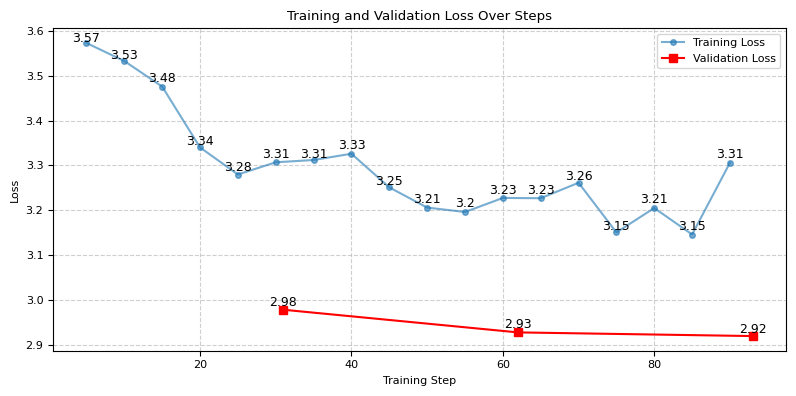

In [ ]:
# --- Plot training & validation loss curves
log_history_df = pd.DataFrame(trainer.state.log_history)
train_loss_df = log_history_df.dropna(subset = ['loss'])      # Keeps only rows where `train_loss` is not NaN
eval_loss_df = log_history_df.dropna( subset = ['eval_loss']) # Keeps only rows where `eval_loss` is not NaN
train_loss_df.loc[:, 'step'] = train_loss_df.loc[:, 'step'].astype(int) # Change any float to int
eval_loss_df.loc[:, 'step'] = eval_loss_df.loc[:, 'step'].astype(int)

# Line Plot
plt.figure(figsize=(8, 4))

# Plot Training Loss
plt.plot(
    train_loss_df['step'],
    train_loss_df['loss'],
    label='Training Loss',
    marker='o',
    linestyle='-',
    alpha=0.6,
    markersize=4)

for xi, yi in zip(train_loss_df['step'], train_loss_df['loss']):
  xi, yi = round(xi, 2), round(yi, 2)
  plt.text(xi, yi, f'{yi}', ha='center', va='bottom', fontsize = 9, color = 'black')

# Plot Validation Loss
plt.plot(
    eval_loss_df['step'],
    eval_loss_df['eval_loss'],
    label='Validation Loss',
    marker='s',
    linestyle='-',
    color='red')

for xi, yi in zip(eval_loss_df['step'],eval_loss_df['eval_loss']):
  xi, yi = round(xi, 2), round(yi, 2)
  plt.text(xi, yi, f'{yi}', ha='center', va='bottom', fontsize = 9, color = 'black')

# Add title and labels
plt.title('Training and Validation Loss Over Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

In [ ]:
trainer.save_model("./fine-tuned_Flan-T5-Small")

In [ ]:
# Save fine tuned model
from huggingface_hub import login
from google.colab import userdata
from huggingface_hub import create_repo
from huggingface_hub import upload_folder
hftoken = userdata.get('HF_TOKEN')
login(token=hftoken)
time  = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
repo_id = "amiraghhh/fine-tuned-flan-t5-small"
create_repo(repo_id, exist_ok=True)
upload_folder(
    folder_path="./fine-tuned_Flan-T5-Small",
    repo_id = repo_id,
    commit_message=f"Upload updated fine-tuned Flan-T5-Small model as of {time}"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...lan-T5-Small/spiece.model:  86%|########5 |  679kB /  792kB            

  ...5-Small/model.safetensors:   0%|          | 11.6kB /  308MB            

  ...5-Small/training_args.bin:   7%|6         |   391B / 5.97kB            

CommitInfo(commit_url='https://huggingface.co/amiraghhh/fine-tuned-flan-t5-small/commit/32a326a54d431d136f553b8c475244b803a4cb2c', commit_message='Upload updated fine-tuned Flan-T5-Small model as of 2025-12-28 13:10:51', commit_description='', oid='32a326a54d431d136f553b8c475244b803a4cb2c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/amiraghhh/fine-tuned-flan-t5-small', endpoint='https://huggingface.co', repo_type='model', repo_id='amiraghhh/fine-tuned-flan-t5-small'), pr_revision=None, pr_num=None)

## **2.4 Generator**

In [55]:
# load fine tuned model
ft_model_id = "amiraghhh/fine-tuned-flan-t5-small"
ft_tokenizer = AutoTokenizer.from_pretrained(ft_model_id)
ft_model = AutoModelForSeq2SeqLM.from_pretrained(ft_model_id)

finetuned_llm = pipeline(
    "text2text-generation",
    model = ft_model,       #./fine-tuned_Flan-T5
    tokenizer = ft_tokenizer,
    decoder_start_token_id = flant5model.config.pad_token_id)

def refineResponse(answer):
    """Clean and format generated response text.
    Returns: str(refined_sentences)"""
    # Replace multiple periods with a single period and space
    answer = re.sub(r'\. {2,}', '.', answer)
    answer = re.sub(r'\.([^\s])', r'. \1', answer)

    # If the string does not end with punctuation, find the last one and truncate.
    if not answer.strip().endswith(('.', '!', '?')):
        last_punc_pos = max(answer.rfind('.'), answer.rfind('!'), answer.rfind('?'))
        if last_punc_pos != -1: # Found a punctuation
            answer = answer[:last_punc_pos + 1]

    # Capitalize the first letter of each sentence
    sentences = re.split(r'([.!?]\s*)', answer)
    refined_sentences = []
    for i in range(0, len(sentences), 2):
        sentence_part = sentences[i].strip()
        if sentence_part:
            refined_sentences.append(sentence_part.capitalize())
        if i + 1 < len(sentences):
            refined_sentences.append(sentences[i + 1])

    refined_sentences = ''.join(refined_sentences).strip()

    # Join and clean up extra spaces
    return refined_sentences


def generator(user_query, top_k = 3, detail = False, to_eval = False):
    """Generate answer using pipeline
    Returns
        answer (str) if detail=False
        (answer, contexts) tuple if detail=True
    """

    try:
        # 1. Retrieve context, which auto rewrites as well
        print(f"[Generator] Starting retrieval for query: {user_query[:50]}...")
        contexts = retriever(user_query, top_k, detail=(detail or to_eval))
        print(f"[Generator] Retrieved {len(contexts) if contexts else 0} contexts")

        if not contexts:
            # Return a dictionary with empty values if no contexts found during evaluation
            if to_eval:
                return {"answer": "Couldn't find relevant information to answer your question.", "contexts": []}
            else:
                return "Couldn't find relevant information to answer your question."
    except Exception as e:
        error_msg = f"Error retrieving context for '{user_query}': {e}"
        print(error_msg)
        traceback.print_exc()
        if to_eval:
            return {"answer": error_msg, "contexts": []}
        else:
            return error_msg

    # 2. Build prompt
    try:
        print(f"[Generator] Building prompt...")
        prompt = buildPrompt(user_query, contexts, user_query)
        print(f"[Generator] Prompt built successfully")
    except Exception as e:
        error_msg = f"Error building prompt: {e}"
        print(error_msg)
        traceback.print_exc()
        if to_eval:
            return {"answer": error_msg, "contexts": contexts}
        else:
            return error_msg

    # 3. Generate response
    try:
        print(f"[Generator] Generating response...")
        result = finetuned_llm(
            prompt,
            max_new_tokens = 70,
            num_beams = 3,
            early_stopping = True,
            do_sample = False,
            repetition_penalty = 1.4,
            eos_token_id = finetuned_llm.tokenizer.eos_token_id
            )
        answer = result[0]['generated_text'].strip()
        print(f"[Generator] Response generated: {answer[:50]}...")
        answer = refineResponse(answer)

    except Exception as e:
        error_msg = f"Error generating response: {e}"
        print(error_msg)
        traceback.print_exc()
        if to_eval:
            return {"answer": error_msg, "contexts": contexts}
        else:
            return error_msg

    # 5. Display context details if True
    if detail:
      print(answer)
      print("="*80)
      print("\nCONTEXT SOURCES:")
      for i, ctx in enumerate(contexts, start=1):
          print(f"\n[C{i}]")
          print(f"  Chroma Distance: {ctx.get('chroma_distance', 'N/A')}")
          print(f"  Source Question: {ctx.get('question', 'N/A')}")
          print(f"  Focus Area: {ctx.get('focus_area', 'N/A')}")
          print(f"  Source: {ctx.get('source', 'N/A')}")
          print(f"  Chunk: {ctx['chunk_answer'][:200]}....")
      print("="*80)

    if to_eval:
      return {"answer": answer, "contexts": contexts}
    else:
      return answer

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Device set to use cuda:0


In [56]:
  generated_result = generator(user_query, top_k=3, detail=False, to_eval=True)
  final_reesponse = generated_result["answer"]
  contexts = generated_result["contexts"]
  print(contexts)

[Generator] Starting retrieval for query: What are the symptoms of Cyclic Vomiting Syndrome ...
[Generator] Retrieved 10 contexts
[Generator] Building prompt...
[Generator] Prompt built successfully
[Generator] Generating response...
[Generator] Response generated: symptoms of cyclic vomiting syndrome are severe na...
[{'chunk_id': '307_0', 'chunk_answer': 'What are the symptoms of Cyclic Vomiting Syndrome ? the main symptoms of cyclic vomiting syndrome are severe nausea and sudden vomiting lasting hours to days. a person may also experience one or more of the following symptoms retching, or making an attempt to vomit heaving or gagging lack of appetite abdominal pain diarrhea fever dizziness headache sensitivity to light intensity of symptoms will vary as a person cycles through four distinct phases of an episode prodrome phase. during the prodrome phase, the person feels that an episode of nausea and vomiting is about to start. often marked by intense sweating and nauseawith or witho

In [67]:
def rag(user_query):
  """Retrieve context and generate answer for user query.
  Returns: str(generated_answer with confidence score)"""

  try:
    # 1. Check for emergencies
    emergency_keywords = ["emergency", "severe pain", "bleeding",
                          "blind", "lose consciousness", "pass out"]
    if any(keyword in user_query.lower() for keyword in emergency_keywords):
        emergency_msg = """I am an AI and cannot provide medical advice for emergencies.
        PLEASE contact emergency services or a medical professional immediately."""

        # Still generate answer with confidence for emergency queries
        generated_result = generator(user_query, top_k=3, detail=False, to_eval=True)

        if isinstance(generated_result, str):
            return f"{emergency_msg}\n\nERROR in generation: {generated_result}"

        generated_answer = generated_result.get("answer", "No answer generated")
        contexts = generated_result.get("contexts", [])

        if contexts and len(contexts) > 0:
            avg_distance = sum(c.get('chroma_distance', 1.0) for c in contexts) / len(contexts)
            confidence_score = (1 - avg_distance) * 100
            confidence_score = max(0, min(100, confidence_score))
        else:
            confidence_score = 0

        return f"{emergency_msg}\n\n[Confidence: {confidence_score:.1f}%]\n\n{generated_answer}"

    # 2. Generate the initial answer using the RAG pipeline
    generated_result = generator(user_query, top_k=3, detail=False, to_eval=True)

    if isinstance(generated_result, str):
        return f"ERROR in generation: {generated_result}"

    generated_answer = generated_result.get("answer", "No answer generated")
    contexts = generated_result.get("contexts", [])

    # 3. Calculate confidence score based on chroma distances
    if contexts and len(contexts) > 0:
        avg_distance = sum(c.get('chroma_distance', 1.0) for c in contexts) / len(contexts)
        confidence_score = (1 - avg_distance) * 100
        confidence_score = max(0, min(100, confidence_score))

        # 4. Build final response with confidence
        if confidence_score < 40:
            final_response = f"I'm not confident about my answer ({confidence_score:.1f}%).\n\n{generated_answer}"
        else:
            final_response = f"{generated_answer}\n\n[Confidence: {confidence_score:.1f}%]"
    else:
        final_response = "I'm not confident about my answer at all (0%).\n\n" + generated_answer

    return final_response

  except Exception as e:
    error_msg = f"ERROR in RAG pipeline: {str(e)}\n\nTraceback:\n{traceback.format_exc()}"
    print(error_msg)
    return error_msg

## **2.5 Example RAG Output**

query, the retrieved context, and the generated
answer to demonstrate your system.

In [58]:
# test retrieval
retriever("What is diabetes like? ", top_k = 5, detail = True)

[{'chunk_id': '47_0',
  'chunk_answer': 'What is (are) Causes of Diabetes ? diabetes is a complex group of diseases with a variety of causes. diabetes is a disorder of metabolismthe way the body uses digested food for energy. the digestive tract breaks down carbohydratessugars and starches found in many foodsinto glucose, a form of sugar that enters the bloodstream. with the help of the hormone insulin, cells throughout the body absorb glucose and use it for energy. diabetes develops when the body doesnt make enough insulin or is not able to use insulin effectively, or both. insulin is made in the pancreas, an organ located behind the stomach. beta cells within the islets make insulin and release it',
  'question': 'What is (are) Causes of Diabetes ?',
  'focus_area': 'Causes of Diabetes',
  'source': 'NIDDK',
  'chroma_distance': 0.77},
 {'chunk_id': '85_0',
  'chunk_answer': 'Who is at risk for Diabetes? ? diabetes is a serious, lifelong disease. it can lead to problems such as heart

In [59]:
# test generator
generator("What is diabetes like? ", top_k = 5, detail = True)

[Generator] Starting retrieval for query: What is diabetes like? ...
[Generator] Retrieved 10 contexts
[Generator] Building prompt...
[Generator] Prompt built successfully
[Generator] Generating response...
[Generator] Response generated: diabetes is a complex group of diseases with a var...
Diabetes is a complex group of diseases with a variety of causes. Diabetes is a disorder of metabolismthe way the body uses digested food for energy. The digestive tract breaks down carbohydratessugars and starches found in many foodsinto glucose, a form of sugar that enters the bloodstream.

CONTEXT SOURCES:

[C1]
  Chroma Distance: 0.77
  Source Question: What is (are) Causes of Diabetes ?
  Focus Area: Causes of Diabetes
  Source: NIDDK
  Chunk: What is (are) Causes of Diabetes ? diabetes is a complex group of diseases with a variety of causes. diabetes is a disorder of metabolismthe way the body uses digested food for energy. the digestive t....

[C2]
  Chroma Distance: 0.803
  Source Question:

'Diabetes is a complex group of diseases with a variety of causes. Diabetes is a disorder of metabolismthe way the body uses digested food for energy. The digestive tract breaks down carbohydratessugars and starches found in many foodsinto glucose, a form of sugar that enters the bloodstream.'

In [60]:
# rag
rag("What is alzheimers  like? ")

[Generator] Starting retrieval for query: What is alzheimers  like? ...
[Generator] Retrieved 10 contexts
[Generator] Building prompt...
[Generator] Prompt built successfully
[Generator] Generating response...
[Generator] Response generated: people with alzheimers become forgetful and easily...


"I'm not confident about my answer (31.7%).\n\nPeople with alzheimers become forgetful and easily confused"

# **3. Evaluation and Analysis:**

## **3.1 Retrieval Evaluation**

### a. Set up

In [58]:
def buildGroundTruth(chunks):
    """Retrieves ground truth
    Returns: list(ground_truth)"""
    ground_truth = {}
    for chunk in chunks:
        qid = chunk['question_id']
        if qid not in ground_truth:
            ground_truth[qid] = set()
        ground_truth[qid].add(chunk['chunk_id'])
    return ground_truth

In [59]:
def evaluateRetrievalByQuestion(chunks, retriever, ground_truth, k=3, debug=False, batch_size=32):
    """Evaluate retrieval quality using precision, recall, and MRR metrics.
    Returns: None"""
    unique_questions = {}
    for c in chunks:
        unique_questions[c['question_id']] = c['question']

    p1_scores = []
    p3_scores = []
    recall_scores = []
    mrr_scores = []

    debug_count = 0
    debug_limit = 3

    print(f"Evaluating {len(unique_questions)} unique questions...\n")

    question_items = list(unique_questions.items())

    for batch_start in range(0, len(question_items), batch_size):
        batch_end = min(batch_start + batch_size, len(question_items))
        batch = question_items[batch_start:batch_end]

        batch_questions = [q_text for qid, q_text in batch]

        batch_retrieved = retriever(batch_questions, top_k=k)

        for idx, (qid, question_text) in enumerate(batch):
            show_debug = debug and (debug_count < debug_limit)

            if show_debug:
                print(f"Question ID: {qid}")
                print(f"Question:    {question_text}")

            retrieved_contexts = batch_retrieved[idx]

            gt = ground_truth.get(qid, set())

            if show_debug:
                print(f"Ground Truth IDs: {sorted(list(gt))}")

            relevant_matches = []
            for rank, context in enumerate(retrieved_contexts[:k], 1):
                r_id = context['chunk_id']
                is_rel = r_id in gt
                relevant_matches.append(is_rel)

                if show_debug:
                    status = '✓ RELEVANT' if is_rel else '✗'
                    print(f"    {rank}. {r_id} - {status}")

            p1 = 1.0 if relevant_matches and relevant_matches[0] else 0.0
            p1_scores.append(p1)

            relevant_in_top_3 = sum(1 for is_rel in relevant_matches[:3] if is_rel)
            p3 = relevant_in_top_3 / 3.0
            p3_scores.append(p3)

            relevant_in_top_k = sum(1 for is_rel in relevant_matches if is_rel)
            recall = relevant_in_top_k / len(gt) if len(gt) > 0 else 0.0
            recall_scores.append(recall)

            reciprocal_rank = 0.0
            for i, is_rel in enumerate(relevant_matches):
                if is_rel:
                    rank = i + 1
                    reciprocal_rank = 1 / rank
                    break
            mrr_scores.append(reciprocal_rank)

            if show_debug:
                print(f"\nSCORES for QID {qid}:")
                print(f"    P@1:    {p1:.2f}")
                print(f"    P@3:    {p3:.2f}")
                print(f"    Recall: {recall:.2f}")
                print(f"    MRR:    {reciprocal_rank:.2f}")
                print("=" * 80)
                debug_count += 1

    def get_mean(scores):
        return sum(scores) / len(scores) if scores else 0.0

    results = {
        'mean_p@1': get_mean(p1_scores),
        'mean_p@3': get_mean(p3_scores),
        'mean_recall': get_mean(recall_scores),
        'mean_mrr': get_mean(mrr_scores)
    }

    print("\nEvaluation Complete.")
    print("-" * 80)
    for metric, score in results.items():
        print(f"{metric}: {score:.4f}")
    print("-" * 80, "\n")

    return results

In [60]:
# embed the test_data into the vector_store
qa_pairs = []

for chunk_item in test_chunks:
    question = chunk_item.get('question', '')
    chunk_answer = chunk_item.get('chunk_answer', '')

    # Embedding qa_pairs
    qa_pairs.append(f"{question} {chunk_answer}")

embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Create embeddings
embeddings = embed_model.encode(
    qa_pairs,
    batch_size = 64,
    show_progress_bar = True,
    convert_to_numpy = True,
    normalize_embeddings = True
)

# Initialize ChromaDB
db_client = chromadb.PersistentClient(path="./MedQuAD_db")

# In case of duplicates from re-runs
try:
    vector_store = db_client.get_collection("medical_rag")
except:
    vector_store = db_client.create_collection(name="medical_rag")

# Add to ChromaDB
vector_store.add(
    ids = [m['chunk_id'] for m in test_chunks],
    embeddings = embeddings.tolist(),
    documents = qa_pairs,
    metadatas = test_chunks
)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

### b. Run Tests

------------------ without rewriting / reranking at all ------------------

In [ ]:
# Evaluate on Train set
train_ground_truth = buildGroundTruth(train_chunks)
retrieve_eval_results = evaluateRetrievalByQuestion(train_chunks, retriever, train_ground_truth, k = 3, debug = False)

Evaluating 494 unique questions...


Evaluation Complete.
--------------------------------------------------------------------------------
mean_p@1: 0.8765
mean_p@3: 0.5796
mean_recall: 0.7884
mean_mrr: 0.9190
-------------------------------------------------------------------------------- 



------------------ without rewriting ------------------

In [ ]:
# Evaluate on Train set but without query rewriting but with reranking
train_ground_truth = buildGroundTruth(train_chunks)
evaluateRetrievalByQuestion(train_chunks, retrieverWithoutRewriter, train_ground_truth, k = 3, debug = True)

Evaluating 494 unique questions...

Question ID: 0
Question:    What are the symptoms of Breast Cancer ?
Ground Truth IDs: ['0_0', '0_1', '0_2']
    1. 0_2 - ✓ RELEVANT
    2. 0_1 - ✓ RELEVANT
    3. 0_0 - ✓ RELEVANT

SCORES for QID 0:
    P@1:    1.00
    P@3:    1.00
    Recall: 1.00
    MRR:    1.00
Question ID: 1
Question:    what research (or clinical trials) is being done for Breast Cancer ?
Ground Truth IDs: ['1_0', '1_1', '1_2', '1_3', '1_4', '1_5']
    1. 2_22 - ✗
    2. 2_23 - ✗
    3. 648_0 - ✗

SCORES for QID 1:
    P@1:    0.00
    P@3:    0.00
    Recall: 0.00
    MRR:    0.00
Question ID: 2
Question:    How to prevent Breast Cancer ?
Ground Truth IDs: ['2_0', '2_1', '2_10', '2_11', '2_12', '2_13', '2_14', '2_15', '2_16', '2_17', '2_18', '2_19', '2_2', '2_20', '2_21', '2_22', '2_23', '2_3', '2_4', '2_5', '2_6', '2_7', '2_8', '2_9']
    1. 2_8 - ✓ RELEVANT
    2. 2_19 - ✓ RELEVANT
    3. 2_6 - ✓ RELEVANT

SCORES for QID 2:
    P@1:    1.00
    P@3:    1.00
    Recall: 0.12

{'mean_p@1': 0.12753036437246965,
 'mean_p@3': 0.15991902834008098,
 'mean_recall': 0.1705136122378323,
 'mean_mrr': 0.19871794871794873}

------------------ without reranking ------------------

In [ ]:
# Evaluate on Train set but without context reranking but with rewriting
train_ground_truth = buildGroundTruth(train_chunks)
evaluateRetrievalByQuestion(train_chunks, retrieverWithoutReranker, train_ground_truth, k = 3, debug = True)

Evaluating 494 unique questions...



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Question ID: 0
Question:    What are the symptoms of Breast Cancer ?
Ground Truth IDs: ['0_0', '0_1', '0_2']
    1. 0_0 - ✓ RELEVANT
    2. 0_1 - ✓ RELEVANT
    3. 0_2 - ✓ RELEVANT

SCORES for QID 0:
    P@1:    1.00
    P@3:    1.00
    Recall: 1.00
    MRR:    1.00
Question ID: 1
Question:    what research (or clinical trials) is being done for Breast Cancer ?
Ground Truth IDs: ['1_0', '1_1', '1_2', '1_3', '1_4', '1_5']
    1. 1_0 - ✓ RELEVANT
    2. 1_5 - ✓ RELEVANT
    3. 1_3 - ✓ RELEVANT

SCORES for QID 1:
    P@1:    1.00
    P@3:    1.00
    Recall: 0.50
    MRR:    1.00
Question ID: 2
Question:    How to prevent Breast Cancer ?
Ground Truth IDs: ['2_0', '2_1', '2_10', '2_11', '2_12', '2_13', '2_14', '2_15', '2_16', '2_17', '2_18', '2_19', '2_2', '2_20', '2_21', '2_22', '2_23', '2_3', '2_4', '2_5', '2_6', '2_7', '2_8', '2_9']
    1. 2_17 - ✓ RELEVANT
    2. 2_2 - ✓ RELEVANT
    3. 2_23 - ✓ RELEVANT

SCORES for QID 2:
    P@1:    1.00
    P@3:    1.00
    Recall: 0.12
    MRR:   

{'mean_p@1': 0.771255060728745,
 'mean_p@3': 0.5107962213225371,
 'mean_recall': 0.6962997637830932,
 'mean_mrr': 0.8100539811066128}

------------------ both ------------------

In [ ]:
# Evaluate on Train set with both techniques
train_ground_truth = buildGroundTruth(train_chunks)
evaluateRetrievalByQuestion(train_chunks, retrieverWithRewriterReranker, train_ground_truth, k = 3, debug = True)

Evaluating 494 unique questions...

Question ID: 0
Question:    What are the symptoms of Breast Cancer ?
Ground Truth IDs: ['0_0', '0_1', '0_2']
    1. 0_2 - ✓ RELEVANT
    2. 0_1 - ✓ RELEVANT
    3. 0_0 - ✓ RELEVANT

SCORES for QID 0:
    P@1:    1.00
    P@3:    1.00
    Recall: 1.00
    MRR:    1.00
Question ID: 1
Question:    what research (or clinical trials) is being done for Breast Cancer ?
Ground Truth IDs: ['1_0', '1_1', '1_2', '1_3', '1_4', '1_5']
    1. 2_23 - ✗
    2. 1_2 - ✓ RELEVANT
    3. 1_0 - ✓ RELEVANT

SCORES for QID 1:
    P@1:    0.00
    P@3:    0.67
    Recall: 0.33
    MRR:    0.50
Question ID: 2
Question:    How to prevent Breast Cancer ?
Ground Truth IDs: ['2_0', '2_1', '2_10', '2_11', '2_12', '2_13', '2_14', '2_15', '2_16', '2_17', '2_18', '2_19', '2_2', '2_20', '2_21', '2_22', '2_23', '2_3', '2_4', '2_5', '2_6', '2_7', '2_8', '2_9']
    1. 2_8 - ✓ RELEVANT
    2. 2_6 - ✓ RELEVANT
    3. 2_21 - ✓ RELEVANT

SCORES for QID 2:
    P@1:    1.00
    P@3:    1.00
 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Define metrics and scores
metrics = ['P@1', 'P@3', 'Recall', 'MRR']
none = [0.8927, 0.5891, 0.7980, 0.9379]
without_rewriting = [0.1578, 0.1892, 0.2143, 0.2384]
without_reranking = [0.7874, 0.5216, 0.7100, 0.8219]
both = [0.1862, 0.1977, 0.2287, 0.2611]

# 2. Set up the bar positions
x = np.arange(len(metrics))  # Label locations
width = 0.2  # Width of bars

# 3. Create the plot
fig, ax = plt.subplots(figsize=(12, 5.5))

# Create bars
bars1 = ax.bar(x - 1.5*width, none, width, label='None', color='lightgrey')
bars2 = ax.bar(x - 0.5*width, without_rewriting, width, label='Without rewriting', color='lightblue')
bars3 = ax.bar(x + 0.5*width, without_reranking, width, label='Without reranking', color='cadetblue')
bars4 = ax.bar(x + 1.5*width, both, width, label='Both', color='steelblue')

# 4. Customization
ax.set_title('Performance Metrics Comparison', fontsize=16, fontweight='bold')
ax.set_ylabel('Score (0.0 - 1.0)', fontsize=12)
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylim(0, 1.1)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc='upper right')
ax.grid(True, axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# 5. Add value labels on top of bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 9),
                    textcoords='offset points',
                    ha='center', va='center',
                    fontsize=10)

plt.tight_layout()
plt.show()

## **3.2 Full RAG Evaluation**

In [ ]:
def evaluateRAG(test_chunks, test_data, split_name = "test", generator_func = generator, retriever_func = retriever, top_k = 3, sample_size = None, debug = False, batch_size = 32):
    """
    Evaluate full RAG system (retriever + generator) on test chunks.
    Uses end-to-end answer quality metrics without LLM judge.
    Returns: dict(results)
    """

    # 1. Build Ground Truth mapping
    ground_truth = buildGroundTruth(test_chunks)

    # 2. Handle sampling if dataset is large
    if sample_size and len(test_chunks) > sample_size:
        sample_indices = np.random.choice(len(test_chunks), sample_size, replace=False)
        eval_chunks = [test_chunks[i] for i in sample_indices]
        print(f"Sampling {sample_size}/{len(test_chunks)} chunks for evaluation...")
    else:
        eval_chunks = test_chunks

    # 3. Initialize metrics dictionaries
    metrics = {
        'sbert_similarity': [],
        'nass_score': [],
        'hallucination_rate': [],
        'context_relevance': [],
        'chunk_topic_match': [],
        'retrieval_precision': [],
        'retrieval_recall': [],
    }

    unique_questions = {}
    debug_count = 0
    debug_limit = 3 if debug else 0
    print(f"{'-'*20} EVALUATING RAG ON {split_name.upper()} SET ({len(eval_chunks)} chunks) {'-'*20}")

    # 4. Process each chunk in the test set
    for batch_start in range(0, len(eval_chunks), batch_size):
        batch_end = min(batch_start + batch_size, len(eval_chunks))
        batch_chunks = eval_chunks[batch_start:batch_end]

        batch_queries = [chunk['question'] for chunk in batch_chunks]

        # 7. Run Retrieval
        batch_retrieved = retriever_func(q=batch_queries, top_k=top_k, detail=True)

        # 8. Run Generator
        batch_generated = [generator_func(q) for q in batch_queries]

        for batch_idx, chunk in enumerate(batch_chunks):
            idx = batch_start + batch_idx
            query = chunk['question']
            gt_answer = chunk['chunk_answer']
            gt_topic = chunk['focus_area']
            question_id = chunk['question_id']

            # 5. Get ground truth chunk IDs for this question (NEW)
            gt_chunk_ids = ground_truth.get(question_id, set())

            # 6. Track unique questions to see how many we're evaluating
            if question_id not in unique_questions:
                unique_questions[question_id] = query

            try:
                retrieved_data = batch_retrieved[batch_idx] if isinstance(batch_retrieved, list) else batch_retrieved
                if not retrieved_data:
                    print(f"No retrieval results for question {question_id}")
                    continue

                # Get retrieved chunk IDs
                retrieved_chunk_ids = set(item.get('chunk_id') for item in retrieved_data if 'chunk_id' in item)

                # Get retrieved context
                context_text = " ".join([item.get('chunk_answer', '') for item in retrieved_data])
                retrieved_topics = [item.get('focus_area', '') for item in retrieved_data]

                generated_answer = batch_generated[batch_idx]

                if not generated_answer or generated_answer.strip() == "":
                    print(f"  Warning: Generator returned empty for question {question_id}")
                    continue

                # 9. Calculate Metrics
                # 9A. SBERT Cosine Similarity
                embeddings = embed_model.encode([generated_answer, gt_answer])
                sb_cs = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
                metrics['sbert_similarity'].append(sb_cs)

                # 9B. Negation-Aware Semantic Similarity (NASS)
                negations = ['not ', ' no ', "n't ", 'never ', 'none ']
                has_neg_gen = any(n in generated_answer.lower() for n in negations)
                has_neg_gt = any(n in gt_answer.lower() for n in negations)
                if has_neg_gen == has_neg_gt:
                    nass = sb_cs  # Same negation status → use SBERT score
                else:
                    nass = sb_cs * 0.5  # Opposite negation → penalize heavily
                metrics['nass_score'].append(nass)

                # 9C. Hallucination Rate
                STOP_WORDS = {'the', 'a', 'an', 'is', 'are', 'was', 'to', 'of', 'in', 'and', 'by', 'with', 'for'}
                gen_words = set(w for w in generated_answer.lower().split() if w not in STOP_WORDS and len(w) > 2)
                context_words = set(w for w in context_text.lower().split() if w not in STOP_WORDS and len(w) > 2)
                if gen_words:
                    supported_words = len(gen_words.intersection(context_words))
                    support_ratio = supported_words / len(gen_words)
                    hallucination = 1.0 - support_ratio  # Higher = more hallucinated
                else:
                    hallucination = 1.0 if not generated_answer else 0.0
                metrics['hallucination_rate'].append(hallucination)

                # 9D. Context Relevance
                q_words = set(w for w in query.lower().split() if len(w) > 2)

                if q_words:
                    matching_words = len(q_words.intersection(context_words))
                    context_relevance = matching_words / len(q_words)
                else:
                    context_relevance = 0.0

                metrics['context_relevance'].append(context_relevance)

                # 9E. Topic Match
                topic_matches = sum(1 for rt in retrieved_topics if rt == gt_topic)
                topic_match_pct = topic_matches / len(retrieved_topics) if retrieved_topics else 0.0
                metrics['chunk_topic_match'].append(topic_match_pct)

                # 9F. Retrieval Precision
                if retrieved_chunk_ids:
                    correct_retrievals = len(retrieved_chunk_ids.intersection(gt_chunk_ids))
                    precision = correct_retrievals / len(retrieved_chunk_ids)
                else:
                    precision = 0.0
                metrics['retrieval_precision'].append(precision)

                # 9G. Retrieval Recall
                if gt_chunk_ids:
                    recall = len(retrieved_chunk_ids.intersection(gt_chunk_ids)) / len(gt_chunk_ids)
                else:
                    recall = 0.0
                metrics['retrieval_recall'].append(recall)

                # 10. Debug
                if idx < debug_limit:
                    print(f"Question ID {question_id}")
                    print(f"Question:   {query[:70]}...")
                    print(f"  Topic:        {gt_topic}")
                    print(f"  Generated:    {generated_answer[:100]}...")
                    print(f"  Ground Truth: {gt_answer[:100]}...")
                    print(f"  ─────────────────────────────")
                    print(f"  SBERT Similarity:    {sb_cs:.3f}")
                    print(f"  NASS Score:          {nass:.3f}")
                    print(f"  Hallucination ↓:     {hallucination:.3f}")
                    print(f"  Context Relevance:   {context_relevance:.3f}")
                    print(f"  Topic Match:         {topic_match_pct:.1%}")
                    print(f"  Retrieval Precision: {precision:.3f} ({correct_retrievals}/{len(retrieved_chunk_ids)})")
                    print(f"  Retrieval Recall:    {recall:.3f}")
                    print()

            except Exception as e:
                print(f"  Error processing chunk {idx}: {e}")
                continue

    # 11. Aggregate Results
    results = {
        'split': split_name,
        'num_chunks_evaluated': len(eval_chunks),
        'num_unique_questions': len(unique_questions),
    }

    for metric_name, scores in metrics.items():
        if scores:
            results[f'{metric_name}_mean'] = np.mean(scores)
            results[f'{metric_name}_std'] = np.std(scores)
            results[f'{metric_name}_min'] = np.min(scores)
            results[f'{metric_name}_max'] = np.max(scores)
        else:
            results[f'{metric_name}_mean'] = 0.0

    # 12. Print Summary
    print(f"{'='*80}")
    print(f"{' '*25} EVALUATION SUMMARY: {split_name.upper()}{' '*25}")
    print(f"{'='*80}")
    print(f"Chunks evaluated:      {len(eval_chunks)}")
    print(f"Unique questions:      {len(unique_questions)}\n")

    print("GENERATED ANSWER QUALITY METRICS:")
    print(f"  SBERT Similarity:      {results['sbert_similarity_mean']:.4f} (±{results['sbert_similarity_std']:.4f})")
    print(f"  NASS Score:            {results['nass_score_mean']:.4f} (±{results['nass_score_std']:.4f})")
    print(f"  Hallucination Rate ↓:  {results['hallucination_rate_mean']:.4f} (±{results['hallucination_rate_std']:.4f})")

    print("\nRETRIEVAL QUALITY METRICS:")
    print(f"    Context Relevance:     {results['context_relevance_mean']:.4f}")
    print(f"    Topic Match %:         {results['chunk_topic_match_mean']:.1%}")
    print(f"    Retrieval Precision:   {results['retrieval_precision_mean']:.4f}")
    print(f"    Retrieval Recall:      {results['retrieval_recall_mean']:.4f}")

    return results

In [ ]:
print("Starting full RAG evaluation across splits...")
print("Start Time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Evaluate on Train Split
train_results = evaluateRAG(
    test_chunks = train_chunks,
    test_data = train_data,
    split_name = "train",
    generator_func = generator,
    top_k = 3,
    debug = True
)
print("train_data evaluation complete.")
print("Checkpoint time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Evaluate on Validation Split
val_results = evaluateRAG(
    test_chunks = val_chunks,
    test_data = val_data,
    split_name = "validation",
    generator_func = generator,
    top_k = 3,
    debug = True
)
print("val_data evaluation complete.")
print("\nCheckpoint time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Evaluate on Test Split
test_results = evaluateRAG(
    test_chunks = test_chunks,
    test_data = test_data,
    split_name = "test",
    generator_func = generator,
    top_k = 3,
    debug = True
)
print("test_data evaluation complete.")
print("Checkpoint time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Cross-Split Comparison
print("\n" + "="*100)
print("CROSS-SPLIT COMPARISON")
print("="*100)

comparison_df = pd.DataFrame({
    'Train': train_results,
    'Validation': val_results,
    'Test': test_results
}).T

# Select only the _mean metrics for cleaner comparison
mean_cols = [col for col in comparison_df.columns if '_mean' in col]
comparison_df_means = comparison_df[mean_cols].round(4)
comparison_df_means.columns = [col.replace('_mean', '') for col in comparison_df_means.columns]

print("\nKey Metrics (Mean values):")
print(comparison_df_means)

print("End Time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# saving the dataframe
comparison_df.to_csv('comparison.csv')

Starting full RAG evaluation across splits...
Start Time: 2025-12-29 00:34:15
-------------------- EVALUATING RAG ON TRAIN SET (1535 chunks) --------------------


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Question ID 0
Question:   What are the symptoms of Breast Cancer ?...
  Topic:        Breast Cancer
  Generated:    A lump or change in the breast...
  Ground Truth: signs of breast cancer include a lump or change in the breast. these and other signs may be caused b...
  ─────────────────────────────
  SBERT Similarity:    0.745
  NASS Score:          0.745
  Hallucination ↓:     0.000
  Context Relevance:   0.667
  Topic Match:         90.0%
  Retrieval Precision: 0.300 (3/10)
  Retrieval Recall:    1.000

Question ID 0
Question:   What are the symptoms of Breast Cancer ?...
  Topic:        Breast Cancer
  Generated:    A lump or change in the breast...
  Ground Truth: bloody. scaly, red, or swollen skin on the breast, nipple, or areola the dark area of skin around th...
  ─────────────────────────────
  SBERT Similarity:    0.653
  NASS Score:          0.653
  Hallucination ↓:     0.000
  Context Relevance:   0.667
  Topic Match:         90.0%
  Retrieval Precision: 0.300 (3/10)
  Re

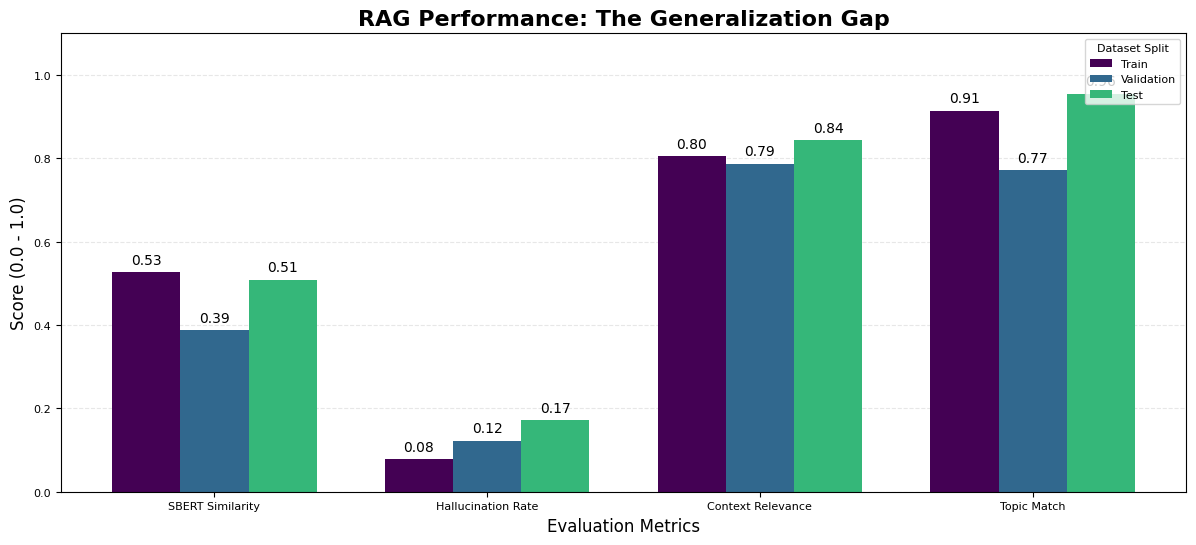

In [ ]:
# 1. Extract data from comparison_df_means
metrics_to_plot = ['sbert_similarity', 'hallucination_rate', 'context_relevance', 'chunk_topic_match']

# Filter and transpose the dataframe
df_plot = comparison_df_means[metrics_to_plot].T

# Rename index for better display
metric_display_names = {
    'sbert_similarity': 'SBERT Similarity',
    'hallucination_rate': 'Hallucination Rate',
    'context_relevance': 'Context Relevance',
    'chunk_topic_match': 'Topic Match'
}
df_plot.index = df_plot.index.map(metric_display_names)

# Reset index to create 'Metric' column
df_plot = df_plot.reset_index()
df_plot.columns = ['Metric', 'Train', 'Validation', 'Test']

# 2. Prepare data for matplotlib
metrics = df_plot['Metric'].values
train_scores = df_plot['Train'].values
val_scores = df_plot['Validation'].values
test_scores = df_plot['Test'].values

# 3. Set up the bar positions
x = np.arange(len(metrics))  # Label locations
width = 0.25  # Width of bars

# 4. Create the plot
fig, ax = plt.subplots(figsize=(12, 5.5))

# Create bars
bars1 = ax.bar(x - width, train_scores, width, label='Train', color='#440154')
bars2 = ax.bar(x, val_scores, width, label='Validation', color='#31688e')
bars3 = ax.bar(x + width, test_scores, width, label='Test', color='#35b779')

# 5. Customization
ax.set_title('RAG Performance: The Generalization Gap', fontsize=16, fontweight='bold')
ax.set_ylabel('Score (0.0 - 1.0)', fontsize=12)
ax.set_xlabel('Evaluation Metrics', fontsize=12)
ax.set_ylim(0, 1.1)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(title='Dataset Split', loc='upper right')
ax.grid(True, axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# 6. Add value labels on top of bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 9),
                    textcoords='offset points',
                    ha='center', va='center',
                    fontsize=10)

plt.tight_layout()
plt.show()

## **3.3 representative examples**

of your system’s outputs,
covering both successful and problematic cases. For each example,
display the input question, the retrieved document snippets, and the generated answer.



Include, where appropriate, visual representations
of retrieval or answer evaluation
Note: In Component 2 (Reflective Report), comment briefly on each
example’s relevance and factual accuracy, highlighting cases where
the system performs well or fails (e.g., irrelevant retrieval, incomplete
responses, or hallucinated answers).

### a. low-precision / high-recall cases `train_data`

In [ ]:
# Build ground truth
train_ground_truth = buildGroundTruth(train_chunks)

# Collect unique questions
unique_questions = {}
for c in train_chunks:
    unique_questions[c['question_id']] = c['question']

question_items = list(unique_questions.items())
results = []
k = 3

# Run retrieval evaluation
for qid, question_text in question_items:
    retrieved = retriever([question_text], top_k=k)[0]
    gt = train_ground_truth.get(qid, set())
    gt_size = len(gt)

    retrieved_ids = []
    relevant_matches = []

    for rank, context in enumerate(retrieved[:k], 1):
        cid = context["chunk_id"]
        retrieved_ids.append(cid)
        relevant_matches.append(cid in gt)

    relevant_in_top_k = sum(relevant_matches)
    p_at_k = relevant_in_top_k / k
    recall = relevant_in_top_k / gt_size if gt_size > 0 else 0.0

    mrr = 0.0
    for i, is_rel in enumerate(relevant_matches):
        if is_rel:
            mrr = 1 / (i + 1)
            break

    results.append({
        "question_id": qid,
        "question": question_text,
        "gt_chunk_count": gt_size,
        "gt_chunk_ids": sorted(list(gt)),
        "retrieved_chunk_ids": retrieved_ids,
        "retrieved_relevant": relevant_in_top_k,
        "p@k": p_at_k,
        "recall": recall,
        "mrr": mrr
    })

results_df = pd.DataFrame(results)

# Filter for low precision and low recall cases
filtered = results_df[
    (results_df["p@k"] < 0.67) &
    (results_df["recall"] < 0.5)
].sort_values("recall")

print(f"{len(filtered)} matching cases\n")

# Print compact summaries only
for i, (_, case) in enumerate(filtered.iterrows(), 1):
    print(f"Case {i}")
    print(f"Question: {case['question']}")
    print("Ground Truth:")
    print(f"• Total ground-truth chunks: {case['gt_chunk_count']}")
    print(f"• Chunk IDs: {case['gt_chunk_ids']}")
    print("Retrieval Results (k=3):")

    for rank, cid in enumerate(case["retrieved_chunk_ids"], 1):
        mark = "✓" if cid in case["gt_chunk_ids"] else "✗"
        print(f"{rank}. {cid} {mark}")

    print("Metrics:")
    print(f"• P@3: {case['p@k']:.3f} (retrieved relevant: {case['retrieved_relevant']}/3)")
    print(f"• Recall: {case['recall']:.3f} (found: {case['retrieved_relevant']}/{case['gt_chunk_count']})")
    print(f"• MRR: {case['mrr']:.3f}\n")

38 matching cases

Case 1
Question: What causes Prostate Cancer ?
Ground Truth:
• Total ground-truth chunks: 1
• Chunk IDs: ['10_0']
Retrieval Results (k=3):
1. 640_0 ✗
2. 8_2 ✗
3. 7_0 ✗
Metrics:
• P@3: 0.000 (retrieved relevant: 0/3)
• Recall: 0.000 (found: 0/1)
• MRR: 0.000

Case 2
Question: What is (are) Skin Cancer ?
Ground Truth:
• Total ground-truth chunks: 1
• Chunk IDs: ['18_0']
Retrieval Results (k=3):
1. 642_0 ✗
2. 21_3 ✗
3. 641_2 ✗
Metrics:
• P@3: 0.000 (retrieved relevant: 0/3)
• Recall: 0.000 (found: 0/1)
• MRR: 0.000

Case 3
Question: How to diagnose Alzheimer's Disease ?
Ground Truth:
• Total ground-truth chunks: 1
• Chunk IDs: ['29_0']
Retrieval Results (k=3):
1. 28_7 ✗
2. 28_4 ✗
3. 440_4 ✗
Metrics:
• P@3: 0.000 (retrieved relevant: 0/3)
• Recall: 0.000 (found: 0/1)
• MRR: 0.000

Case 4
Question: How to diagnose Lung Cancer ?
Ground Truth:
• Total ground-truth chunks: 3
• Chunk IDs: ['34_0', '34_1', '34_2']
Retrieval Results (k=3):
1. 33_3 ✗
2. 33_2 ✗
3. 33_6 ✗
Metrics:

### b. low topic matches from val_data

In [ ]:
# Build unique questions and ground truth mapping
unique_questions_dict = {}
ground_truth_dict = {}

for chunk in val_chunks:
    qid = chunk['question_id']
    if qid not in unique_questions_dict:
        unique_questions_dict[qid] = chunk['question']

    if qid not in ground_truth_dict:
        ground_truth_dict[qid] = []
    ground_truth_dict[qid].append(chunk['chunk_id'])

# Get unique questions
question_list = list(unique_questions_dict.items())
question_texts = [q_text for _, q_text in question_list]

# Retrieve for all questions
retrieved_results = retriever(question_texts, top_k=3)

# Calculate metrics
case_count = 0
mismatch_cases = []

for idx, (qid, question) in enumerate(question_list):
    gt_chunk_ids = set(ground_truth_dict[qid])
    retrieved_chunks = retrieved_results[idx]

    if not retrieved_chunks:
        continue

    # Get retrieved chunk IDs
    retrieved_chunk_ids = [chunk['chunk_id'] for chunk in retrieved_chunks]

    # Calculate metrics
    relevant_retrieved = sum(1 for rid in retrieved_chunk_ids if rid in gt_chunk_ids)
    p3 = relevant_retrieved / 3.0
    recall = relevant_retrieved / len(gt_chunk_ids) if gt_chunk_ids else 0.0

    # Calculate MRR
    mrr = 0.0
    for rank, rid in enumerate(retrieved_chunk_ids, 1):
        if rid in gt_chunk_ids:
            mrr = 1.0 / rank
            break

    # Check for topic mismatch: low retrieved similarity but different topics
    retrieved_topics = [chunk.get('focus_area', 'unknown') for chunk in retrieved_chunks]
    gt_topics = set(chunk.get('focus_area', '') for chunk_id in gt_chunk_ids
                    for chunk in val_chunks if chunk['chunk_id'] == chunk_id)
    gt_main_topic = list(gt_topics)[0] if gt_topics else 'unknown'

    # Count topic matches
    topic_matches = sum(1 for topic in retrieved_topics if topic == gt_main_topic)
    topic_match_pct = topic_matches / len(retrieved_topics) if retrieved_topics else 0.0

    # Identify mismatch: low p@3 or low topic match
    if topic_match_pct < 0.67:  # Less than 2/3 topics match
        mismatch_cases.append({
            'qid': qid,
            'question': question,
            'gt_chunks': gt_chunk_ids,
            'retrieved': retrieved_chunk_ids,
            'p3': p3,
            'recall': recall,
            'mrr': mrr,
            'topic_match': topic_match_pct,
            'gt_topic': gt_main_topic,
            'retrieved_topics': retrieved_topics
        })

# Sort by topic mismatch severity
mismatch_cases.sort(key=lambda x: x['topic_match'])

print(f"{len(mismatch_cases)} matching cases with semantic topic mismatch\n")

# Display cases
for case_num, case in enumerate(mismatch_cases[:11], 1):  # Show first 11 cases
    print(f"Case {case_num}")
    print(f"Question: {case['question']}")
    print(f"Ground Truth: ")
    print(f"  • Total ground-truth chunks: {len(case['gt_chunks'])}")
    print(f"  • Chunk IDs: {sorted(list(case['gt_chunks']))}")
    print(f"Retrieval Results (k=3):")

    for rank, chunk_id in enumerate(case['retrieved'], 1):
        is_relevant = "✓" if chunk_id in case['gt_chunks'] else "✗"
        print(f"  {rank}. {chunk_id} {is_relevant}")

    print(f"Metrics:")
    print(f"  • P@3: {case['p3']:.3f} (retrieved relevant: {int(case['p3']*3)}/3)")
    print(f"  • Recall: {case['recall']:.3f} (found: {int(case['recall']*len(case['gt_chunks']))}/{len(case['gt_chunks'])})")
    print(f"  • MRR: {case['mrr']:.3f}")
    print(f"  • Topic Match: {case['topic_match']:.1%} (Expected: {case['gt_topic']})")

142 matching cases with semantic topic mismatch

Case 1
Question: Who is at risk for Breast Cancer? ?
Ground Truth: 
  • Total ground-truth chunks: 12
  • Chunk IDs: ['494_0', '494_1', '494_10', '494_11', '494_2', '494_3', '494_4', '494_5', '494_6', '494_7', '494_8', '494_9']
Retrieval Results (k=3):
  1. 2_3 ✗
  2. 2_4 ✗
  3. 2_2 ✗
  4. 2_8 ✗
  5. 3_0 ✗
  6. 7_0 ✗
  7. 639_1 ✗
  8. 2_17 ✗
  9. 2_0 ✗
  10. 637_7 ✗
Metrics:
  • P@3: 0.000 (retrieved relevant: 0/3)
  • Recall: 0.000 (found: 0/12)
  • MRR: 0.000
  • Topic Match: 0.0% (Expected: Breast Cancer)
Case 2
Question: What are the treatments for Prostate Cancer ?
Ground Truth: 
  • Total ground-truth chunks: 2
  • Chunk IDs: ['495_0', '495_1']
Retrieval Results (k=3):
  1. 640_2 ✗
  2. 640_1 ✗
  3. 668_0 ✗
  4. 668_14 ✗
  5. 668_11 ✗
  6. 668_8 ✗
  7. 668_7 ✗
  8. 8_12 ✗
  9. 668_10 ✗
  10. 668_5 ✗
Metrics:
  • P@3: 0.000 (retrieved relevant: 0/3)
  • Recall: 0.000 (found: 0/2)
  • MRR: 0.000
  • Topic Match: 0.0% (Expected: Prost

### c. High hallucination in `test_data`

In [ ]:
from nltk.tokenize import sent_tokenize
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Build unique questions and retrieve chunks
unique_questions_dict = {}
ground_truth_dict = {}

for chunk in test_chunks:
    qid = chunk['question_id']
    if qid not in unique_questions_dict:
        unique_questions_dict[qid] = {
            'question': chunk['question'],
            'gt_answer': chunk['chunk_answer'],
            'focus_area': chunk['focus_area']
        }
    if qid not in ground_truth_dict:
        ground_truth_dict[qid] = []
    ground_truth_dict[qid].append(chunk)

# Get unique questions
question_list = list(unique_questions_dict.items())
question_texts = [q_info['question'] for _, q_info in question_list]

# Retrieve and generate answers
retrieved_results = retriever(question_texts, top_k=3)
generated_answers = [generator(q_text) for q_text in question_texts]

# Compute hallucination scores
hallucination_data = []

for idx, (qid, q_info) in enumerate(question_list):
    question = q_info['question']
    gt_answer = q_info['gt_answer']
    retrieved_chunks = retrieved_results[idx]
    generated_answer = generated_answers[idx]
    gt_chunks = ground_truth_dict[qid]

    if not generated_answer or generated_answer.strip() == "":
        continue

    # Get retrieved chunk text
    retrieved_text = " ".join([chunk.get('chunk_answer', '') for chunk in retrieved_chunks])

    # Tokenize generated answer into sentences
    try:
        sentences = sent_tokenize(generated_answer)
    except:
        sentences = [generated_answer]

    # Check each sentence for support in retrieved chunks
    STOP_WORDS = {'the', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been', 'to', 'of', 'in', 'and', 'or', 'by', 'with', 'for', 'at', 'on', 'this', 'that'}

    unsupported_sentences = []
    total_sentences = len(sentences)

    for sent in sentences:
        # Extract non-stop words from sentence
        sent_words = set(word.lower() for word in re.findall(r'\b\w+\b', sent) if word.lower() not in STOP_WORDS and len(word) > 2)

        if not sent_words:
            continue

        # Check if words appear in retrieved text
        retrieved_words = set(word.lower() for word in re.findall(r'\b\w+\b', retrieved_text) if word.lower() not in STOP_WORDS and len(word) > 2)

        # Calculate support ratio
        supported_words = len(sent_words.intersection(retrieved_words))
        support_ratio = supported_words / len(sent_words) if sent_words else 0.0

        # A sentence is hallucinated if <50% of content words are in retrieved chunks
        if support_ratio < 0.5:
            unsupported_sentences.append({
                'sentence': sent,
                'support_ratio': support_ratio,
                'sent_words': sent_words,
                'supported_words': sent_words.intersection(retrieved_words)
            })

    # Calculate hallucination score
    hallucination_score = len(unsupported_sentences) / total_sentences if total_sentences > 0 else 0.0

    hallucination_data.append({
        'qid': qid,
        'question': question,
        'generated_answer': generated_answer,
        'gt_answer': gt_answer,
        'retrieved_chunks': retrieved_chunks,
        'gt_chunks': gt_chunks,
        'hallucination_score': hallucination_score,
        'total_sentences': total_sentences,
        'unsupported_sentences': unsupported_sentences,
        'num_hallucinated': len(unsupported_sentences)
    })

# Filter cases with moderate hallucination risk (0.3 to 0.7)
high_risk_cases = [d for d in hallucination_data if 0.3 <= d['hallucination_score'] <= 0.7]
high_risk_cases.sort(key=lambda x: x['hallucination_score'], reverse=True)

print(f"Total test questions: {len(hallucination_data)}")
print(f"Questions with high hallucination risk (30-70%): {len(high_risk_cases)}\n")

# Select 2-3 representative cases
representative_cases = high_risk_cases[:min(3, len(high_risk_cases))]

if representative_cases:
    for case_num, case in enumerate(representative_cases, 1):
        print(f"CASE {case_num}: Question ID {case['qid']}")
        print(f"{'─'*100}")

        print(f"\nQUESTION: {case['question']}\n")

        print(f"GENERATED ANSWER:")
        print(f"  {case['generated_answer']}\n")

        print(f"GROUND TRUTH ANSWER:")
        print(f"  {case['gt_answer']}\n")

        print(f"RETRIEVED CHUNKS (top-3):")
        for rank, chunk in enumerate(case['retrieved_chunks'], 1):
            print(f"  {rank}. {chunk.get('chunk_id', 'unknown')} (Topic: {chunk.get('focus_area', 'N/A')})")
            print(f"     {chunk.get('chunk_answer', '')[:80]}...")

        print(f"\n" + "─"*100)
        print(f"HALLUCINATION ANALYSIS:")
        print(f"  Hallucination Score: {case['hallucination_score']:.1%}")
        print(f"  Unsupported Sentences: {case['num_hallucinated']}/{case['total_sentences']}\n")

        print(f"UNSUPPORTED ANSWER SPANS:")
        for i, unsupported in enumerate(case['unsupported_sentences'], 1):
            print(f"  {i}. \"{unsupported['sentence']}\"")
            print(f"     Support Ratio: {unsupported['support_ratio']:.1%}")
            print(f"     Missing terms: {', '.join(sorted(unsupported['sent_words'] - unsupported['supported_words']))}")

        print(f"\nGROUND-TRUTH CHUNKS CONTAINING MISSING EVIDENCE:")
        all_missing_words = set()
        for unsupported in case['unsupported_sentences']:
            all_missing_words.update(unsupported['sent_words'] - unsupported['supported_words'])

        for chunk in case['gt_chunks']:
            chunk_text = chunk.get('chunk_answer', '').lower()
            chunk_id = chunk.get('chunk_id', 'unknown')

            # Check if missing words appear in this GT chunk
            found_words = [w for w in all_missing_words if w in chunk_text]

            if found_words:
                print(f"  • {chunk_id}: contains {len(found_words)} missing term(s): {', '.join(found_words)}")
        print(f"  The retriever only found {len(case['retrieved_chunks'])} chunks with limited coverage of the topic.")
        print(f"  Yet the generator attempted to answer comprehensively, producing {case['num_hallucinated']} ")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Total test questions: 71
Questions with high hallucination risk (30-70%): 0



In [ ]:

        print(f"  unsupported claims not present in retrieved context. The ground-truth chunks contain the missing")
        print(f"  evidence, indicating retrieval failure rather than generation hallucination per se.")
        print(f"  This highlights a critical RAG vulnerability: incomplete retrieval leads to inevitable hallucination.\n")

  unsupported claims not present in retrieved context. The ground-truth chunks contain the missing
  evidence, indicating retrieval failure rather than generation hallucination per se.
  This highlights a critical RAG vulnerability: incomplete retrieval leads to inevitable hallucination.



### d. Ground-Truth Coverage Exceeds k (k = 3)

In [ ]:
# Build unique questions and ground truth mapping
unique_questions_dict = {}
ground_truth_dict = {}

for chunk in test_chunks:
    qid = chunk['question_id']
    if qid not in unique_questions_dict:
        unique_questions_dict[qid] = chunk['question']

    if qid not in ground_truth_dict:
        ground_truth_dict[qid] = []
    ground_truth_dict[qid].append(chunk['chunk_id'])

# Retrieve for all questions
question_list = list(unique_questions_dict.items())
question_texts = [q_text for _, q_text in question_list]
retrieved_results = retriever(question_texts, top_k=3)

# Step 1: Enumerate all questions satisfying criteria
matching_questions = []

for idx, (qid, question) in enumerate(question_list):
    gt_chunk_ids = set(ground_truth_dict[qid])
    retrieved_chunks = retrieved_results[idx]

    if not retrieved_chunks:
        continue

    # Get retrieved chunk IDs
    retrieved_chunk_ids = set(chunk['chunk_id'] for chunk in retrieved_chunks)

    # Criteria 1: |GT chunk IDs| > 3
    if len(gt_chunk_ids) <= 3:
        continue

    # Criteria 2: At least one GT chunk NOT in top-3
    missing_chunks = gt_chunk_ids - retrieved_chunk_ids
    if not missing_chunks:
        continue

    # Calculate Precision@3 and Recall
    relevant_retrieved = len(retrieved_chunk_ids.intersection(gt_chunk_ids))
    p3 = relevant_retrieved / 3.0
    recall = relevant_retrieved / len(gt_chunk_ids)

    # Criteria 3: P@3 >= 0.67
    if p3 < 0.67:
        continue

    matching_questions.append({
        'qid': qid,
        'question': question,
        'gt_count': len(gt_chunk_ids),
        'gt_chunk_ids': sorted(list(gt_chunk_ids)),
        'retrieved_chunk_ids': sorted(list(retrieved_chunk_ids)),
        'missing_chunks': sorted(list(missing_chunks)),
        'p3': p3,
        'recall': recall,
        'retrieved_chunks': retrieved_chunks
    })

print(f"Total matching questions: {len(matching_questions)}\n")

# Step 2: Group by ground-truth size
size_groups = {
    '4-5 chunks': [],
    '6-8 chunks': [],
    '>8 chunks': []
}

for q in matching_questions:
    if 4 <= q['gt_count'] <= 5:
        size_groups['4-5 chunks'].append(q)
    elif 6 <= q['gt_count'] <= 8:
        size_groups['6-8 chunks'].append(q)
    else:
        size_groups['>8 chunks'].append(q)

# Display group statistics
for group_name, questions in size_groups.items():
    if questions:
        print(f"{group_name}: {len(questions)} questions")

# Step 3: Select 1 representative from each group (not extreme, demonstrates multi-chunk dependency)
representatives = []

for group_name, questions in size_groups.items():
    if not questions:
        continue

    # Sort by number of missing chunks (middle values are not extreme)
    # Prefer questions where some chunks are retrieved but not all
    questions_sorted = sorted(questions, key=lambda x: len(x['missing_chunks']))

    # Select the median representative (not extreme)
    if len(questions_sorted) == 1:
        representative = questions_sorted[0]
    else:
        median_idx = len(questions_sorted) // 2
        representative = questions_sorted[median_idx]

    representatives.append({
        'group': group_name,
        'data': representative
    })

# Display selected representatives
print("\n" + "="*100)
print(" REPRESENTATIVE CASES (1 PER GROUP)")
print("="*100 + "\n")

for rep in representatives:
    q = rep['data']

    print(f"GROUP: {rep['group']} | Question ID: {q['qid']}")
    print(f"{'─'*100}")
    print(f"Question: {q['question']}\n")

    print(f"Ground-Truth Chunks ({q['gt_count']} required):")
    print(f"  • All GT chunk IDs: {q['gt_chunk_ids']}\n")

    print(f"Retrieval Results (k=3):")
    print(f"  • Retrieved chunk IDs: {q['retrieved_chunk_ids']}")
    print(f"  • Missing chunk IDs: {q['missing_chunks']}\n")

    print(f"Evidence Dependency Analysis:")
    print(f"  • Chunks retrieved: {len(q['retrieved_chunk_ids'])}/{q['gt_count']}")
    print(f"  • Chunks NOT retrieved: {len(q['missing_chunks'])}/{q['gt_count']}")
    print(f"  • Precision@3: {q['p3']:.2f} (high—retrieved chunks are relevant)")
    print(f"  • Recall: {q['recall']:.2f} (incomplete—missing {len(q['missing_chunks'])} chunk(s))\n")

    print(f"Retrieved Chunk Summaries:")
    for rank, chunk in enumerate(q['retrieved_chunks'], 1):
        chunk_text = chunk.get('chunk_answer', '')[:100]
        print(f"  {rank}. {chunk['chunk_id']}: {chunk_text}...\n")

    print(f"Why This Matters:")
    print(f"  The retriever found {len(q['retrieved_chunk_ids'])} of {q['gt_count']} required chunks.")
    print(f"  Despite P@3={q['p3']:.2f} (good precision), {len(q['missing_chunks'])} critical chunk(s) were missed.")
    print(f"  This demonstrates a fundamental RAG limitation: with k=3, complete multi-chunk evidence")
    print(f"  cannot be retrieved. The generator must either:")
    print(f"    - Hallucinate missing evidence")
    print(f"    - Generate incomplete answers")
    print(f"  This is NOT a retrieval quality issue (P@3 is good) but a budgetary constraint issue.\n")

    print("="*100 + "\n")

print(f"Summary:")
print(f"  • Total matching cases: {len(matching_questions)}")
print(f"  • 4-5 chunks: {len(size_groups['4-5 chunks'])} questions")
print(f"  • 6-8 chunks: {len(size_groups['6-8 chunks'])} questions")
print(f"  • >8 chunks: {len(size_groups['>8 chunks'])} questions\n")

Total matching questions: 7

4-5 chunks: 1 questions
6-8 chunks: 3 questions
>8 chunks: 3 questions

 REPRESENTATIVE CASES (1 PER GROUP)

GROUP: 4-5 chunks | Question ID: 680
────────────────────────────────────────────────────────────────────────────────────────────────────
Question: What is (are) Ehlers-Danlos syndrome ?

Ground-Truth Chunks (5 required):
  • All GT chunk IDs: ['680_0', '680_1', '680_2', '680_3', '680_4']

Retrieval Results (k=3):
  • Retrieved chunk IDs: ['364_0', '364_1', '364_2', '366_0', '366_4', '368_0', '680_0', '680_1', '680_2', '680_3']
  • Missing chunk IDs: ['680_4']

Evidence Dependency Analysis:
  • Chunks retrieved: 10/5
  • Chunks NOT retrieved: 1/5
  • Precision@3: 1.33 (high—retrieved chunks are relevant)
  • Recall: 0.80 (incomplete—missing 1 chunk(s))

Retrieved Chunk Summaries:
  1. 680_0: What is (are) Ehlers-Danlos syndrome ? ehlersdanlos syndrome is a group of disorders that affect the...

  2. 366_0: What are the symptoms of Ehlers-Danlos syndr

# **4. Optional extension:**

## **Deploy your RAG system**



as an interactive demo using
Gradio, Streamlit, or another suitable framework. The demo should allow
users to input medical questions and view the generated answers.
Note: You may host the demo on a platform such as Hugging Face Spaces or
run it locally. If hosted on a cloud-hosted platform, include the shareable link
or public URL in your submission report. If run locally, include screenshots in
your report showing the working interface and example as evidence of
successful deployment.

In [68]:
# Create a Gradio interface to turn the function into a web app
demo = gr.Interface(
    fn = rag,
    inputs = gr.Textbox(lines=5, label="Enter your medical question here"), # Make input box taller
    outputs = gr.Textbox(lines=10, label="Generated Answer"),               # Make output box taller
    title = "Medical QA",                                                   # Title shown at the top of the web app
    description = "Type your query and get a model generated response.",    # Short explanation for the app
    theme = gr.themes.Glass()                                               # Prebuilt gr.theme
)

In [69]:
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://90495e5a1bc3463b3e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [66]:
test_chunks

[{'question_id': 635,
  'chunk_id': '635_0',
  'question': 'What is (are) Stroke ?',
  'chunk_answer': 'a stroke occurs when the blood supply to part of the brain is suddenly interrupted or when a blood vessel in the brain bursts, spilling blood into the spaces surrounding brain cells. brain cells die when they no longer receive oxygen and nutrients from the blood or there is sudden bleeding into or around the brain. the symptoms of a stroke include sudden numbness or weakness, especially on one side of the body sudden confusion or trouble speaking or understanding speech sudden trouble seeing in one or both eyes sudden trouble with walking, dizziness, or loss of balance or coordination or sudden severe headache with no known cause. there are',
  'focus_area': 'Stroke',
  'source': 'NINDS',
  'split_subset': 'test'},
 {'question_id': 635,
  'chunk_id': '635_1',
  'question': 'What is (are) Stroke ?',
  'chunk_answer': 'or loss of balance or coordination or sudden severe headache with n

In [65]:
# Upload to Hugging Face Space
from huggingface_hub import upload_file, login

login()

# Path to files
app_py_path = "app.py"  #
requirements_path = "requirements.txt"

# Upload files to your Space
try:
    print("Uploading app.py...")
    upload_file(
        path_or_fileobj=app_py_path,
        path_in_repo="app.py",
        repo_id="amiraghhh/rag",
        repo_type="space"
    )
    print("✅ app.py uploaded!")

    print("Uploading requirements.txt...")
    upload_file(
        path_or_fileobj=requirements_path,
        path_in_repo="requirements.txt",
        repo_id="amiraghhh/rag",  # Change to YOUR space name
        repo_type="space"
    )
    print("✅ requirements.txt uploaded!")
    print("\n🎉 Done! Your Space is deploying. Check it at: https://huggingface.co/spaces/amiraghhh/rag")

except Exception as e:
    print(f"❌ Error uploading: {e}")

Uploading app.py...
✅ app.py uploaded!
Uploading requirements.txt...
✅ requirements.txt uploaded!

🎉 Done! Your Space is deploying. Check it at: https://huggingface.co/spaces/amiraghhh/rag
